# Model including Walmart POS data

# <font color='red'>Preprocessing</font>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from keras.utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Input, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.layers import concatenate

'''Set parameter in system properties ---> Advanced --->Environment Variables--->System variables--->New..
Variable - MKL_THREADING_LAYER
Value - GNU'''

Using TensorFlow backend.


'Set parameter in system properties ---> Advanced --->Environment Variables--->System variables--->New..\nVariable - MKL_THREADING_LAYER\nValue - GNU'

In [3]:
from sklearn.utils import class_weight
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from utils import Reshape

## Parameters

In [4]:
PREFILTER = True
PREFILTER_THRESHOLD = 0.2 # Data excluded if Brand variance greather than 0.2M or less than -0.2M

WINDOW_SIZE = 13 # Timeseries window size in months

UNDERSAMPLE = True
UNDERSAMPLE_RATIO = 0.7 #  Amount of data with no comment =  Amount of data with comment / UNDERSAMPLE_RATIO
EXTRA_TEST_DATA = 100 # Amount of data thrown out when undersampling to include in the test set

OVERSAMPLE = True

AUGMENT_DATA = True

DATA = ["Variance", "POS"] # "Variance", "All", 
MODEL = "LSTM"    # 

#Karim
RUN_GRID_SEARCH = 0

## Loading Data

commentaries_to_pickle.py to save commentary spreedsheet to pickle

In [5]:
from helper_save_load import load_from_pickle

df_c = load_from_pickle("../data/Labeled_comments2.pkl")
# df_c.drop(columns=['Safeway', 'Baseline'], inplace=True) # If Labeled_comments.pkl

In [9]:
df_a, df_f, df_v = load_from_pickle("../data/dataframes_Dollars.pickle")
del df_a, df_f

In [10]:
territories = [territory for territory, values in df_v.groupby(['Territory']).groups.items()]

In [11]:
pos_with_brands = load_from_pickle('../data/pos_with_brands.pickle')
pos_with_brands['UnitPrice'] = pos_with_brands['TotalSales'] / pos_with_brands['TotalQty']

pos_with_brands.replace([np.inf, -np.inf], 0, inplace=True) # Replace ~0 / 0 with zero

In [12]:
inv_with_brands = load_from_pickle('../data/inventory_with_brands.pickle')


## Pre-Filtering Data
Including data if variance is greater than the 0.2M threshold

In [13]:
test = df_c[(~df_c["Num"].duplicated())]
len(test[test["NoComm"] == 1]) / len(test) # Fraction of number of brand-month pairs with no commentaries

0.7415946205571565

In [14]:
len(test[test["NoComm"] == 1])

772

In [15]:
if PREFILTER:
    df_c = df_c[(df_c["Variance"] >= PREFILTER_THRESHOLD) | (df_c["Variance"] <= -PREFILTER_THRESHOLD)]

In [16]:
test = df_c[(~df_c["Num"].duplicated())]
len(test[test["NoComm"] == 1]) / len(test) #Fraction of number of brand-month pairs with no commentaries after filtering


0.12237762237762238

In [17]:
df_c[df_c["Num"] == 225]["Commentaries"]

1136    MP oversell $0.5M vs SOP5, (MBR oversell +$0.8...
1137    Balance driven by IMP at OOH MD Build cycling ...
Name: Commentaries, dtype: object

In [ ]:
df_c[df_c[territory_label_cols].sum(1) ==0][["Num"] + territory_label_cols]

In [19]:
len(test) - 35

251

In [20]:
len(test[test["NoComm"] == 1])

35

## Removing multiclass labels

Rows with multiple positive class labels are changed to a single label according to the importance of the class

In [21]:
CLASS_PRIORITY = [...] # Most important class to predict to least

print('Number of multiclass labels before:', sum(df_c[label_cols].sum(axis=1) > 1))
      
for idx, row in df_c[df_c[label_cols[:4]].sum(axis=1) > 1][label_cols[:4]].iterrows():
    positive_label_idx = min([CLASS_PRIORITY.index(c) for c in row[row > 0].index])
    negative_labels = CLASS_PRIORITY[:]
    negative_labels.pop(positive_label_idx) # List of columns to set to zero
    df_c.loc[idx, negative_labels] = 0

print('Number of multiclass labels after:', sum(df_c[label_cols].sum(axis=1) > 1))

Number of multiclass labels before: 38
Number of multiclass labels after: 0


## Reshaping Data

In [22]:
TR_BR_grouped = df_v.groupby(["Territory", "Brand"]).sum()

In [23]:
# Relevant Territories Dictionary
# Also Grouping LCL, Sobeys, Metro, OOH
# METRO ONT/QUE FDS AND HPC? (23)
# Liquidation?

# territory_dict = {"WM":[27], "Sobeys":[11, 12, 13, 14], "Sobeys W":[14], "SobeysQ":[12],
#                   "Metro":[8, 9, 10], "Metro ON":[8, 10], "Metro Q":[9, 10], "SDM":[4], 
#                   "LCL":[1, 2, 3], "Costco":[28], "MCK":[5], "PJC":[6], "OOH":[22, 23, 24, 25]}

territory_dict = {}

Summing variances for all associated subterritories for each labeled territory and placing them in a dictionary

In [24]:
variance_dict = {}
for territory, subterritories in territory_dict.items():
    summed_variance = pd.DataFrame()
    for subterritory in subterritories:
        summed_variance = summed_variance.add(TR_BR_grouped.loc[subterritory], fill_value=0)
        
    variance_dict[territory] = summed_variance

In [ ]:
for t, v in variance_dict.items():
    print(t, v.shape)

In [26]:
territory_label_cols = ['WM']
# territory_label_cols = df_c.columns[18:31]

Variance time series (all months) for labeled territories. Zeros if no data for brand-territory.

In [27]:
# Brand x territory x months
# Row of zeros if empty
brands = df_v["Brand"].unique()
months = df_v.columns[8:]

all_brands_variance = []

for brand in brands:
    temp = []
    for territory in territory_label_cols:
        if brand in variance_dict[territory].index:
            temp.append(variance_dict[territory].loc[brand].values)
        else:
            temp.append(np.zeros(len(months)))
    all_brands_variance.append(temp)
    
all_brands_variance = np.array(all_brands_variance)
all_brands_variance.shape

(136, 1, 34)

For each unique brand-month pair (known to be unique by the "Num" column) we take a 12 month window of data for each labeled territory. Thus the output should have #unique brand-month pairs * 13 territories rows.

The labels are generated as well. The default label for when a territory is not involved is [0, 0, 0, 0, 0]

In [28]:
# Generates full list of WINDOW_SIZE length timeseries and corresponding class labels
# for every *unique* brand-month pair in commentary spreadsheet

labels = []
BR_TR_timeseries_windows = []
previous_commentary_num = -1
brand_month_labels = None

for idx, row in df_c.iterrows():
    brand_idx = np.where(brands==row["Brand_1"])[0][0]
    month_idx = np.where(months==row["Month"])[0][0]
    t_idx = np.flatnonzero(row.fillna(0)[territory_label_cols]) # Index of territory_label for this row
    
    # Due to splitting of commentaries we have repeated brand-month pairs in data
    # Keeping track of which commentary so we don't repeat its timeseries
    current_commentary_num = row["Num"] 
    
    if current_commentary_num != previous_commentary_num:
        # First instance of brand-month pair
        labels.append(brand_month_labels)
        
        brand_month_labels = np.zeros((len(territory_label_cols), len(label_cols)), dtype=int)
        brand_month_labels[:, 5] = 1 # Default NoComm
        
        if t_idx.size > 0:
            brand_month_labels[t_idx[0]] = row[label_cols].fillna(0).values
        
        for i in range(len(territory_label_cols)):

            # Appending 12 month windows per brand per territory as input
            if month_idx - WINDOW_SIZE < 0:
                padding = np.zeros(WINDOW_SIZE - month_idx -1) # pad with zeros if less than 12
                window = np.concatenate((padding, all_brands_variance[brand_idx, i, :month_idx+1]))
            else:
                window = all_brands_variance[brand_idx, i, (month_idx-WINDOW_SIZE+1):month_idx+1]
            BR_TR_timeseries_windows.append(window)
    else:
        # Repeated instances of brand-month pair
        if t_idx.size > 0:
            brand_month_labels[t_idx[0]] = row[label_cols].fillna(0).values

    previous_commentary_num = current_commentary_num
    
labels.append(brand_month_labels) # Append the final labels
BR_TR_timeseries_windows = np.array(BR_TR_timeseries_windows)
BR_TR_labels = np.vstack(labels[1:])
BR_TR_timeseries_windows = (BR_TR_timeseries_windows -BR_TR_timeseries_windows.mean()) / BR_TR_timeseries_windows.std()

print("X data shape:", BR_TR_timeseries_windows.shape) # 286 brand-month pairs * 13 territories, 12 months
print("y data shape:", BR_TR_labels.shape)             # 286 brand-month pairs * 13 territories, 5 labels

X data shape: (286, 13)
y data shape: (286, 6)


In [29]:
X = BR_TR_timeseries_windows[:]
y = BR_TR_labels[:]

In [30]:
df_c.Num.nunique() # Number of unique brand-month pairs i.e. number of unsplit commentaries 

286

In [31]:
sum(BR_TR_labels) # Class memberships (Promo, Phasing, SP&D, POS, Other, NoComm)

array([ 30,  11,   4,  19,   3, 219])

Text(0.5, 1.0, 'Class Memberships After Oversampling')

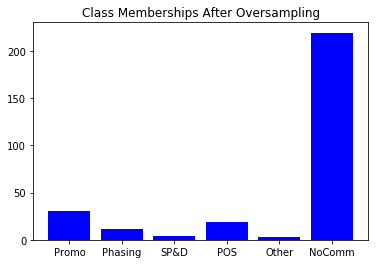

In [32]:
plt.bar(label_cols, sum(y), color='b')
plt.title("Class Memberships After Oversampling")
# plt.savefig('Oversampling.png')

## POS timeseries windows (monthly)

Just using TotalSales column for now. should be adjusted to either include both TotalSales and TotalQty. Or unitprice.

In [33]:
monthly_pos = pos_with_brands.groupby([pos_with_brands["POSDate"].dt.to_period('M'), "Brand"]).\
               agg({"TotalSales":"sum", "TotalQty":"sum", "UnitPrice":"sum"}).reset_index()
monthly_pos['POSDate'] = pd.to_datetime(monthly_pos['POSDate'].astype(str)).dt.strftime('%b_%Y')

In [34]:
unique_brand_month_pairs = df_c[~df_c['Num'].duplicated()][['Num', 'Brand_1', 'Month']]

months = monthly_pos['POSDate'].unique().tolist()
monthly_pos_pivot = pd.pivot_table(monthly_pos, index='Brand', columns='POSDate', values='UnitPrice') 
monthly_pos_pivot = monthly_pos_pivot.reindex(months, axis=1)
monthly_pos_pivot.fillna(0, inplace=True)
brands = monthly_pos_pivot.index.tolist()
monthly_pos_data = monthly_pos_pivot.values

In [35]:
monthly_pos_windows = []
for i, row in unique_brand_month_pairs.iterrows():
    month_idx = months.index(row['Month'])
    brand_idx = brands.index(row['Brand_1'])
    
    if month_idx - WINDOW_SIZE < 0:
        padding = np.zeros(WINDOW_SIZE - month_idx - 1) # pad with zeros if less than WINDOW_SIZE
        window = np.concatenate((padding, monthly_pos_data[brand_idx, :month_idx+1]))
    else:
        window = monthly_pos_data[brand_idx, (month_idx-WINDOW_SIZE+1):month_idx+1]
        
    assert(len(window) == WINDOW_SIZE)
    monthly_pos_windows.append(window)
    
monthly_pos_windows = np.array(monthly_pos_windows)

In [36]:
monthly_pos_windows = (monthly_pos_windows - monthly_pos_windows.mean()) / monthly_pos_windows.std()

## POS timeseries windows (weekly)

In [37]:
weekly_pos = pos_with_brands.groupby([pos_with_brands["POSDate"].dt.to_period('W'), "Brand"]).\
               agg({"TotalSales":"sum", "TotalQty":"sum"}).reset_index()
weekly_pos_pivot = pd.pivot_table(weekly_pos, index='Brand', columns='POSDate', values='TotalSales')

In [38]:
# for brand in brands:
    
# # Label for apr2017 add weeks up to and including weeks in apr2017
    

## Inventory monthly windows

In [39]:
agg_dict = {}

#Are these the right columns to sum/avg?
cols_to_sum = inv_with_brands.columns[2:8].tolist()
cols_to_avg = inv_with_brands.columns[8:-1].to_list()
    
for col in cols_to_sum:
    agg_dict[col] = np.sum

for col in cols_to_avg:
    agg_dict[col] = np.mean

In [40]:
# Should have agg_dict where some columns are summed and some are averaged
monthly_inv = inv_with_brands.groupby([inv_with_brands["POSDate"].dt.to_period("M"), "Brand"]).agg(
                                            agg_dict).reset_index()
monthly_inv['POSDate'] = pd.to_datetime(monthly_inv['POSDate'].astype(str)).dt.strftime('%b_%Y')

In [41]:
months = monthly_inv['POSDate'].unique().tolist()

monthly_inv_pivot = pd.pivot_table(monthly_inv, index='Brand', columns='POSDate', values='CurrStrOnHandQty')
monthly_inv_pivot = monthly_inv_pivot.reindex(months, axis=1)
monthly_inv_pivot.fillna(0, inplace=True)

brands = monthly_inv_pivot.index.tolist()
monthly_inv_data = monthly_inv_pivot.values

In [42]:
monthly_inv_windows = []
for i, row in unique_brand_month_pairs.iterrows():
    month_idx = months.index(row['Month'])
    brand_idx = brands.index(row['Brand_1'])
    
    if month_idx - WINDOW_SIZE < 0:
        padding = np.zeros(WINDOW_SIZE - month_idx - 1) # pad with zeros if less than WINDOW_SIZE
        window = np.concatenate((padding, monthly_inv_data[brand_idx, :month_idx+1]))
    else:
        window = monthly_inv_data[brand_idx, (month_idx-WINDOW_SIZE+1):month_idx+1]
        
    assert(len(window) == WINDOW_SIZE)
    monthly_inv_windows.append(window)
    
monthly_inv_windows = np.array(monthly_inv_windows)

In [43]:
monthly_inv_windows = (monthly_inv_windows - monthly_inv_windows.mean()) / monthly_inv_windows.std()

## Augmenting data with noise

In [44]:
# Adding noise to variance data to generate more samples to learn from

## Making a training and test set (VAR+POS)

In [45]:
from sklearn.model_selection import train_test_split

X = np.concatenate((BR_TR_timeseries_windows, monthly_pos_windows), axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)  
#Karim: random_state changed from 0 to 4, to have more representation of all classes in the test set

X: VAR+POS data concatenated for 12 months for each comment, y: comments categories in six classes (5: NoComment)

In [46]:
print("Whole data:", X.shape, y.shape)
print("Training:", X_train.shape, y_train.shape)
print("Test:",X_test.shape, y_test.shape)

Whole data: (286, 26) (286, 6)
Training: (228, 26) (228, 6)
Test: (58, 26) (58, 6)


In [47]:
print('All data')
print('Len: ', len(y))
print('NoComment: ', np.sum(y[:,5]))
print('Comments: ', len(y)-np.sum(y[:,5]))
print('Number per class: ',np.sum(y, axis=0))

print('\nTraining set')
print('Len: ', len(y_train))
print('NoComment: ', np.sum(y_train[:,5]))
print('Comments: ', len(y_train)-np.sum(y_train[:,5]))
print('Number per class: ',np.sum(y_train, axis=0))

print('\nTest set')
print('Len: ', len(y_test))
print('NoComment: ', np.sum(y_test[:,5]))
print('Comments: ', len(y_test)-np.sum(y_test[:,5]))
print('Number per class: ',np.sum(y_test, axis=0))

print(label_cols)

All data
Len:  286
NoComment:  219
Comments:  67
Number per class:  [ 30  11   4  19   3 219]

Training set
Len:  228
NoComment:  178
Comments:  50
Number per class:  [ 24   7   3  14   2 178]

Test set
Len:  58
NoComment:  41
Comments:  17
Number per class:  [ 6  4  1  5  1 41]
['Promo', 'Phasing', 'SP&D', 'POS', 'Other', 'NoComm']


In [48]:
X_train.shape, len(X_train)

((228, 26), 228)

## Undersampling

In [49]:
if UNDERSAMPLE:
    
    print("Length of data:",len(X_train))
    print("No Comment:", sum(y_train[:, 5] == 1))
    print("With Comment:", sum(y_train[:, 5] == 0))
    
    nonzero_data = np.where(X_train.sum(axis=1) != 0)
    X_train = X_train[nonzero_data]
    y_train = y_train[nonzero_data]
    
    no_comment_idx = np.where(y_train[:, 5] == 1)[0]
    with_comment_idx = np.where(y_train[:, 5] == 0)[0]

    no_comment_count = sum(y_train[:, 5] == 1)   
    with_comment_count = sum(y_train[:, 5] == 0)
    
    np.random.shuffle(no_comment_idx)
    undersample_no_comment_idx = no_comment_idx[:int(with_comment_count/UNDERSAMPLE_RATIO)]
    excluded_data_idx = no_comment_idx[int(with_comment_count/UNDERSAMPLE_RATIO):]
    
    
    undersample_idx = np.concatenate((undersample_no_comment_idx, with_comment_idx))
    undersample_idx.sort(kind='mergesort') # Preserving order of data
    
    excluded_data = X_train[excluded_data_idx]
    excluded_labels = y_train[excluded_data_idx]
    
    X_train = X_train[undersample_idx]
    y_train = y_train[undersample_idx]

Length of data: 228
No Comment: 178
With Comment: 50


In [50]:
print("Length of data:", len(X_train))
print("No Comment:", sum(y_train[:, 5] == 1))
print("With Comment:", sum(y_train[:, 5] == 0))

Length of data: 121
No Comment: 71
With Comment: 50


In [51]:
# Time series with zero data Before and after
sum(BR_TR_timeseries_windows.sum(axis=1)==0), sum(X.sum(axis=1) == 0) 

(0, 0)

## Oversampling small classes

In [52]:
from imblearn.over_sampling import RandomOverSampler

# Naive oversampling
if OVERSAMPLE:
    print("Class memberships before:", sum(y_train))
    ros = RandomOverSampler()
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    print("Class memberships after:", sum(y_resampled))

Class memberships before: [24  7  3 14  2 71]
Class memberships after: [71 71 71 71 71 71]


### Split the data back into var and pos

In [53]:
varX_train = X_resampled[:, :WINDOW_SIZE]
posX_train = X_resampled[:, WINDOW_SIZE:]

varX_test = X_test[:, :WINDOW_SIZE]
posX_test = X_test[:, WINDOW_SIZE:]

## Baseline (RandomForest)

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import confusion_matrix

In [55]:
def plot_feature_importances(model, ax):
    n_features = WINDOW_SIZE*2
    ax.barh(range(n_features), model.feature_importances_, align='center')
#     ax.yticks(np.arange(n_features))
#     ax.setxlabel("Feature importance")
#     ax.ylabel("Feature")
#     ax.ylim(-1, n_features)

<BarContainer object of 26 artists>

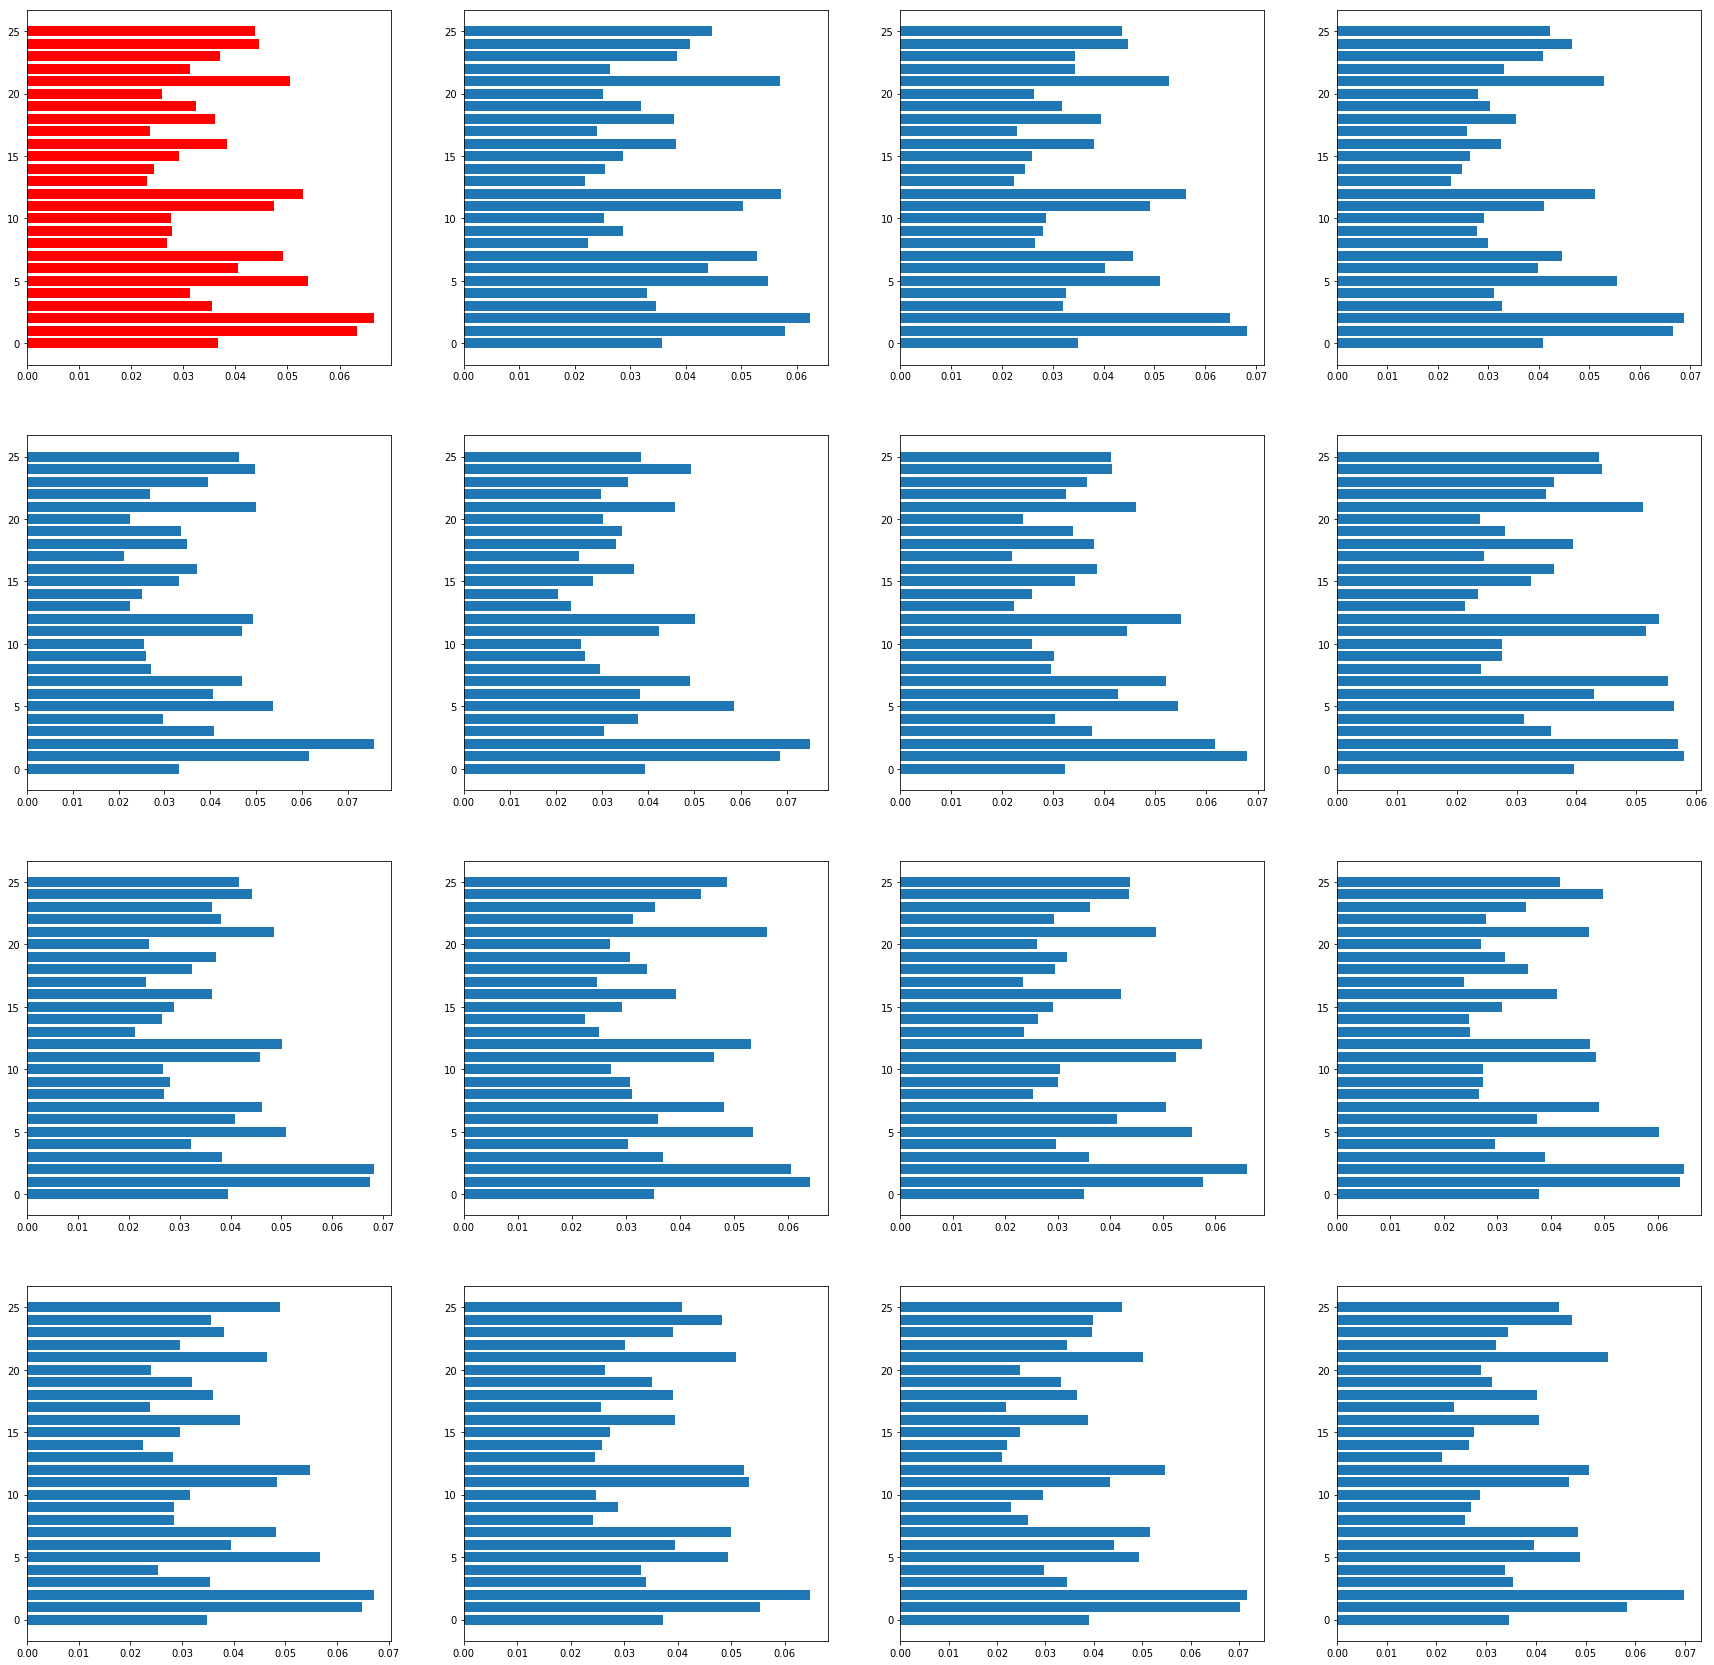

In [56]:
fig, axs = plt.subplots(4, 4, figsize=(30,30))

axs = axs.ravel()

average_feature_importance = np.zeros(WINDOW_SIZE*2)
for i in range(1, 16):
    rf = RandomForestClassifier(200)
    rf.fit(X_resampled, np.argmax(y_resampled, 1))
    average_feature_importance += rf.feature_importances_
    plot_feature_importances(rf, axs[i])
average_feature_importance /= 15
axs[0].barh(range(WINDOW_SIZE*2), average_feature_importance, align='center', color='r')

# <font color='red'>MultiClass classification VAR+POS</font>

In [57]:
#bi-LSTM (Variance and POS)
def create_model(h1=100, h2=60, d1=0.2, rd1=0.2, d2=0.2, rd2=0.2):
    var_input = Input(shape=(WINDOW_SIZE, 1))
    var_lstm = LSTM(h1, dropout=d1, recurrent_dropout=rd1)
    var_output = var_lstm(var_input)

    pos_input = Input(shape=(WINDOW_SIZE, 1))
    pos_lstm = LSTM(h2, dropout=d2, recurrent_dropout=rd2)
    pos_output = pos_lstm(pos_input)

    merged = concatenate([var_output, pos_output])
    classifier = Dense(6, activation='softmax')
    model_output = classifier(merged)

    model = Model([var_input, pos_input], model_output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
    
    return model

In [58]:
from sklearn.metrics import precision_score, recall_score, f1_score
def evaluate_model(estimator, runs=10):
    
    metrics = ['precision_macro', 'precision_micro', 'recall_macro', 'recall_micro',
              'f1_macro', 'f1_micro', 'gms_macro', 'gms_micro']
    results = {m:[] for m in metrics}

    for _ in range(runs):
        model = estimator
        model.fit(X_train, np.argmax(y_train, 1))
        y_pred = model.predict(X_test)

        results['precision_macro'].append(precision_score(np.argmax(y_test,1), y_pred, average='macro'))
        results['precision_micro'].append(precision_score(np.argmax(y_test,1), y_pred, average='micro')) 
        results['recall_macro'].append(recall_score(np.argmax(y_test,1), y_pred, average='macro'))
        results['recall_micro'].append(recall_score(np.argmax(y_test,1), y_pred, average='micro'))
        results['f1_macro'].append(f1_score(np.argmax(y_test,1), y_pred, average='macro'))
        results['f1_micro'].append(f1_score(np.argmax(y_test,1), y_pred, average='micro'))
        results['gms_macro'].append(geometric_mean_score(np.argmax(y_test,1), y_pred, average='macro'))
        results['gms_micro'].append(geometric_mean_score(np.argmax(y_test,1), y_pred, average='micro'))
    
    return results

In [59]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.metrics import geometric_mean_score
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from utils import SplitAndReshape


if RUN_GRID_SEARCH:
    model = Pipeline([
        ('sampling', RandomOverSampler()), 
        ('reshape', SplitAndReshape()),
        ('clf', KerasClassifier(create_model, verbose=0))
    ])

    # Grid search parameters
    hidden_size1 = [80] #40, 60, 80]
    hidden_size2 = [100]  # [100, 120,150]
    epochs =  [80, 100]  #  [60, 80, 100]
    batch_size = [32] # [8, 16, 32]
    dropout1 = [0.2] # [0.2, 0.5]
    dropout2 = [0.2] # [0.2, 0.5]
    r_dropout1 = [0.2] # [0.2, 0.5]
    r_dropout2 = [0.2] # [0.2, 0.5]

    scoring={'f1_macro':'f1_macro', 
             'f1_micro':'f1_micro', 
             'gms_macro':make_scorer(geometric_mean_score, average='macro'), 
             'gms_micro':make_scorer(geometric_mean_score, average='micro')}

    param_grid = {'clf__h1':hidden_size1,
                  'clf__h2':hidden_size2,
                  'clf__batch_size':batch_size,
                  'clf__epochs':epochs,
                  'clf__d1':dropout1,
                  'clf__rd1':r_dropout1,
                  'clf__d2':dropout2,
                  'clf__rd2':r_dropout2}

    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=5, n_jobs=-1, refit='f1_macro')

    grid_search = grid.fit(X_train, np.argmax(y_train, axis=1))

In [60]:
if RUN_GRID_SEARCH:
    grid_search.best_params_

In [61]:
if RUN_GRID_SEARCH:
    scores = grid_search.cv_results_['mean_test_f1_macro']
    # f1_micro = grid_search.cv_results_['mean_test_f1_micro']
    # f1_macro = grid_search.cv_results_['mean_test_f1_macro']
    params = grid_search.cv_results_['params']

    for score, param in zip(scores, params):
        if score > 0.21:
            print(score, param)

In [62]:
model_lstm_v_p = Pipeline([
    ('sampling', RandomOverSampler()), 
    ('reshape', SplitAndReshape()),
    ('clf', KerasClassifier(create_model, epochs=60, batch_size=16, verbose=0))
])

In [63]:
results = evaluate_model(model_lstm_v_p,2)   #TODO: Karim rerun for 10 (without 2)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


precision_macro 0.208
precision_micro 0.448
recall_macro 0.23
recall_micro 0.448
f1_macro 0.211
f1_micro 0.448
gms_macro 0.439
gms_micro 0.631


In [64]:
import eli5
from eli5.sklearn import PermutationImportance
from matplotlib.colors import to_hex

def color_dataframe(row):
    color = to_hex(plt.cm.RdBu(row.weight* 10 +0.5))
    return pd.Series('background-color: %s' % color, row.index)

def permutation_importance(estimator, runs=10):
    
    weights = np.zeros(26)
    std = np.zeros(26)
    for _ in range(runs):
        model = estimator
        model.fit(X_train, np.argmax(y_train,1))

        perm = PermutationImportance(model, scoring='f1_macro').fit(X_test, np.argmax(y_test, 1))
        df = eli5.format_as_dataframe(eli5.explain_weights(perm, top=26, feature_names=[str(i) for i in range(26)]))
        df['feature'] = pd.to_numeric(df['feature'])
        df.sort_values(by='feature', inplace=True)
        
        weights += df['weight'].values
        std += df['std'].values
        
    weights /= runs
    std /= runs
    features = ['Var_Month'+ str(i) for i in range(0,13)] + ['POS_Month'+ str(i) for i in range(13)]

    df_perm_importance = pd.DataFrame(data=np.vstack((weights, std)).T, columns=['weight', 'std'])
    df_perm_importance.insert(0, 'features', features)
    df_perm_importance.sort_values('weight', ascending=False, inplace=True)
    df_perm_importance.reset_index(drop=True, inplace=True)
    
    return df_perm_importance.style.apply(color_dataframe, axis=1)
    

In [65]:
permutation_importance(model_lstm_v_p)

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metr

,features,weight,std
0,Var_Month10,0.0371552,0.0151941
1,Var_Month2,0.0248678,0.0260667
2,Var_Month1,0.0207706,0.0303464
3,Var_Month7,0.017205,0.0204641
4,Var_Month8,0.0164821,0.0228548
5,Var_Month9,0.0156414,0.0206933
6,POS_Month1,0.0144931,0.0147041
7,Var_Month12,0.0136904,0.0237984
8,POS_Month2,0.0093393,0.0164986
9,POS_Month3,0.0082497,0.0259755


In [66]:
import matplotlib.pyplot as plt

%matplotlib inline

def plot_model(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('model loss')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title('model accuracy')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

## Single LSTM model

In [67]:
#Single LSTM (with Sequential implementation)
def var_model(hidden_size=100, dropout=0.2, recurrent_dropout=0.2):
    model = Sequential()
    model.add(LSTM(hidden_size, input_shape=(WINDOW_SIZE, 1),
                  dropout=dropout, recurrent_dropout=recurrent_dropout))
    model.add(Dense(6, activation='softmax')) 
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam')
    return model

In [68]:
#Single LSTM with MultiClass
def create_model0():
    
    var_input = Input(shape=(WINDOW_SIZE, 2))
    var_lstm = LSTM(100, dropout=0.5, recurrent_dropout=0.5)
    var_output = var_lstm(var_input)

#     pos_input = Input(shape=(WINDOW_SIZE, 1))
#     pos_lstm = LSTM(50, dropout=0.5, recurrent_dropout=0.5)
#     pos_output = pos_lstm(pos_input)
# 
#     merged = concatenate([var_output, pos_output])
    classifier = Dense(6, activation='softmax')
    model_output = classifier(var_output)

    model = Model(var_input, model_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    
    return model

In [69]:
X_train.shape

(121, 26)

In [70]:
# X = np.concatenate((BR_TR_timeseries_windows, monthly_pos_windows), axis=1)

X_train_lstm0 = X_train.reshape(((X_train.shape[0], WINDOW_SIZE, 2)), order='F')
X_test_lstm0 = X_test.reshape(((X_test.shape[0], WINDOW_SIZE, 2)), order='F')

In [71]:
X_train.shape

(121, 26)

In [72]:
model_lstm0 = create_model0()
model_lstm0.fit(X_train_lstm0, y_train, validation_split=0.2, epochs=60, batch_size=8)

Train on 96 samples, validate on 25 samples
Epoch 1/60
96/96 [==============================] - 4s 44ms/step - loss: 1.7549 - val_loss: 1.7902
Epoch 2/60
96/96 [==============================] - 0s 2ms/step - loss: 1.7050 - val_loss: 1.6653
Epoch 3/60
96/96 [==============================] - 0s 2ms/step - loss: 1.5660 - val_loss: 1.4163
Epoch 4/60
96/96 [==============================] - 0s 2ms/step - loss: 1.4000 - val_loss: 1.1143
Epoch 5/60
96/96 [==============================] - 0s 2ms/step - loss: 1.3567 - val_loss: 1.0748
Epoch 6/60
96/96 [==============================] - 0s 2ms/step - loss: 1.3105 - val_loss: 1.1378
Epoch 7/60
96/96 [==============================] - 0s 2ms/step - loss: 1.2421 - val_loss: 1.0763
Epoch 8/60
96/96 [==============================] - 0s 2ms/step - loss: 1.2669 - val_loss: 1.0561
Epoch 9/60
96/96 [==============================] - 0s 2ms/step - loss: 1.2986 - val_loss: 1.1378
Epoch 10/60
96/96 [==============================] - 0s 2ms/step - loss: 

In [73]:
from keras.callbacks import ReduceLROnPlateau
model_lstm0 = create_model0()

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

model_lstm0.fit(X_train_lstm0, y_train, validation_split=0.2, epochs=60, batch_size=8, 
          callbacks=[earlyStopping, mcp_save])

/root/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 96 samples, validate on 25 samples
Epoch 1/60
96/96 [==============================] - 4s 45ms/step - loss: 1.7701 - val_loss: 1.7748
Epoch 2/60
96/96 [==============================] - 0s 2ms/step - loss: 1.6249 - val_loss: 1.7331
Epoch 3/60
96/96 [==============================] - 0s 2ms/step - loss: 1.5864 - val_loss: 1.5842
Epoch 4/60
96/96 [==============================] - 0s 2ms/step - loss: 1.4264 - val_loss: 1.3014
Epoch 5/60
96/96 [==============================] - 0s 2ms/step - loss: 1.2933 - val_loss: 1.0572
Epoch 6/60
96/96 [==============================] - 0s 2ms/step - loss: 1.2768 - val_loss: 1.1460
Epoch 7/60
96/96 [==============================] - 0s 2ms/step - loss: 1.2624 - val_loss: 1.1908
Epoch 8/60
96/96 [==============================] - 0s 2ms/step - loss: 1.2726 - val_loss: 1.1456
Epoch 9/60
96/96 [==============================] - 0s 2ms/step - loss: 1.2982 - val_loss: 1.1808
Epoch 10/60
96/96 [==============================] - 0s 2ms/step - loss: 

In [74]:
# plot_model(model_lstm0.history)

In [75]:
#Multiclass classification (xtrain and ytrain as parameters)
def evaluate_model1(estimator, xtrain, xtest, ytrain, ytest, runs=10):
    
    metrics = ['precision_macro', 'precision_micro', 'recall_macro', 'recall_micro',
              'f1_macro', 'f1_micro', 'gms_macro', 'gms_micro']
    results = {m:[] for m in metrics}

    for _ in range(runs):
        model = estimator
        model.fit(xtrain, np.argmax(ytrain, 1))
        y_pred = model.predict(xtest)

        results['precision_macro'].append(precision_score(np.argmax(ytest,1), y_pred, average='macro'))
        results['precision_micro'].append(precision_score(np.argmax(ytest,1), y_pred, average='micro')) 
        results['recall_macro'].append(recall_score(np.argmax(ytest,1), y_pred, average='macro'))
        results['recall_micro'].append(recall_score(np.argmax(ytest,1), y_pred, average='micro'))
        results['f1_macro'].append(f1_score(np.argmax(ytest,1), y_pred, average='macro'))
        results['f1_micro'].append(f1_score(np.argmax(ytest,1), y_pred, average='micro'))
        results['gms_macro'].append(geometric_mean_score(np.argmax(ytest,1), y_pred, average='macro'))
        results['gms_micro'].append(geometric_mean_score(np.argmax(ytest,1), y_pred, average='micro'))
    
    return results

In [76]:
X_train_lstm0.shape

(121, 13, 2)

In [77]:
#Single LSTM

# model_lstm0_v_p = Pipeline([
#     ('sampling', RandomOverSampler()), 
#     ('reshape', SplitAndReshape()),
#     ('clf', KerasClassifier(create_model0, epochs=60, batch_size=16, verbose=1))
# ])

model_lstm0_v_p = Pipeline([
    ('clf', KerasClassifier(create_model0, epochs=60, batch_size=16, verbose=1))
])

results_lstm0_v_p = evaluate_model1(model_lstm0_v_p, X_train_lstm0, X_test_lstm0, y_train, y_test, 2)  
#TODO: Karim rerun for 10 (without 2)
for metric, value in results_lstm0_v_p.items():
    print(metric, np.round(np.mean(value), 3))
    

Epoch 1/60
121/121 [==============================] - 4s 32ms/step - loss: 1.7705
Epoch 2/60
121/121 [==============================] - 0s 1ms/step - loss: 1.7122
Epoch 3/60
121/121 [==============================] - 0s 1ms/step - loss: 1.6182
Epoch 4/60
121/121 [==============================] - 0s 1ms/step - loss: 1.4764
Epoch 5/60
121/121 [==============================] - 0s 1ms/step - loss: 1.3412
Epoch 6/60
121/121 [==============================] - 0s 1ms/step - loss: 1.2777
Epoch 7/60
121/121 [==============================] - 0s 1ms/step - loss: 1.2266
Epoch 8/60
121/121 [==============================] - 0s 1ms/step - loss: 1.2065
Epoch 9/60
121/121 [==============================] - 0s 1ms/step - loss: 1.2257
Epoch 10/60
121/121 [==============================] - 0s 1ms/step - loss: 1.1982
Epoch 11/60
121/121 [==============================] - 0s 1ms/step - loss: 1.2340
Epoch 12/60
121/121 [==============================] - 0s 1ms/step - loss: 1.2046
Epoch 13/60
121/121 [===

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch 1/60
121/121 [==============================] - 4s 33ms/step - loss: 1.7807
Epoch 2/60
121/121 [==============================] - 0s 1ms/step - loss: 1.6940
Epoch 3/60
121/121 [==============================] - 0s 1ms/step - loss: 1.6215
Epoch 4/60
121/121 [==============================] - 0s 1ms/step - loss: 1.4909
Epoch 5/60
121/121 [==============================] - 0s 1ms/step - loss: 1.3412
Epoch 6/60
121/121 [==============================] - 0s 1ms/step - loss: 1.3075
Epoch 7/60
121/121 [==============================] - 0s 1ms/step - loss: 1.2452
Epoch 8/60
121/121 [==============================] - 0s 1ms/step - loss: 1.2278
Epoch 9/60
121/121 [==============================] - 0s 1ms/step - loss: 1.2604
Epoch 10/60
121/121 [==============================] - 0s 1ms/step - loss: 1.1921
Epoch 11/60
121/121 [==============================] - 0s 1ms/step - loss: 1.1933
Epoch 12/60
121/121 [==============================] - 0s 1ms/step - loss: 1.2514
Epoch 13/60
121/121 [===

In [78]:
for metric, value in results_lstm0_v_p.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.202
precision_micro 0.716
recall_macro 0.181
recall_micro 0.716
f1_macro 0.163
f1_micro 0.716
gms_macro 0.389
gms_micro 0.821


In [79]:
from sklearn.model_selection import KFold

pre = []
rec = []
fs = []
gms = []


for tr, te in KFold(n_splits=5, shuffle=True).split(X, y):
    for _ in range(1000):
        predictions = np.random.randint(6, size=len(y[te]))

        pre.append(precision_score(np.argmax(y[te], 1), predictions, average='weighted'))
        rec.append(recall_score(np.argmax(y[te], 1), predictions, average='weighted'))
        fs.append(f1_score(np.argmax(y[te], 1), predictions, average='weighted'))
        gms.append(geometric_mean_score(np.argmax(y[te], 1), predictions, average='weighted'))

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [80]:
print(np.mean(pre), np.mean(rec), np.mean(fs), np.mean(gms))

0.6083195802144639 0.1665452510586812 0.23102526842434262 0.3681284213939444


In [81]:
# print(classification_report_imbalanced(np.argmax(y_test, 1), predictions))

In [82]:
# for tr, te in KFold(n_splits=5, shuffle=True).split(X, y):
#     print('tr=', tr)
#     print(y[te])
#     print('te=', te)

## Random Forest

In [83]:
# Should try with multivariate timeseries

In [84]:
# #Karim: save current X_train and X_test (for 2 LSTM)
# X_train_backup = X_train
# X_test_backup = X_test

In [85]:
# #Karim: Reshape X_train and X_test again
# X_train = X_train.reshape(((X_train.shape[0], WINDOW_SIZE* 2)), order='F')
# X_test = X_test.reshape(((X_test.shape[0], WINDOW_SIZE* 2)), order='F')

In [86]:
X_train.shape

(121, 26)

In [87]:
if RUN_GRID_SEARCH:
    model_rf_v_p = Pipeline([
        ('sampling', RandomOverSampler()),
        ('clf', RandomForestClassifier())
    ])

    # Grid search parameters
    n_estimators = [10, 50, 100, 150, 200]
    max_depth = [3, 5, 7, 9, 11, 13, 15, None]

    scorer = make_scorer(f1_score, average='macro')

    param_grid = {'clf__n_estimators':n_estimators, 'clf__max_depth':max_depth}

    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

    grid_search = grid.fit(X_train, np.argmax(y_train, axis=1))

In [88]:
# Changes everytime
if RUN_GRID_SEARCH:
    grid_search.best_params_

In [89]:
model_rf_v_p = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', RandomForestClassifier(100, max_depth=5))
])

results_rf_v_p = evaluate_model(model_rf_v_p, 100)
for metric, value in results_rf_v_p.items():
    print(metric, np.round(np.mean(value), 3))

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/

precision_macro 0.183
precision_micro 0.515
recall_macro 0.183
recall_micro 0.515
f1_macro 0.179
f1_micro 0.515
gms_macro 0.385
gms_micro 0.681


/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [90]:
feature_importance = np.zeros(26)
for _ in range(100):
    model = Pipeline([
        ('sampling', RandomOverSampler()),
        ('clf', RandomForestClassifier(100, max_depth=7))
    ])
    model.fit(X, np.argmax(y, 1))
    feature_importance += model.steps[1][1].feature_importances_
feature_importance /= 100    

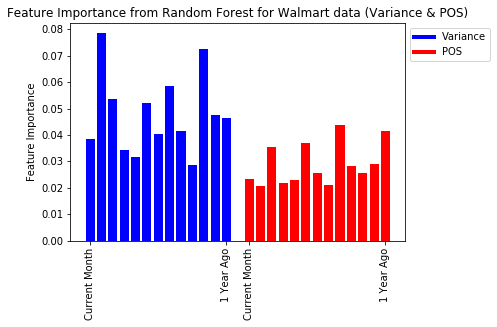

In [91]:
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='b', lw=4, label='Variance'),
                   Line2D([0], [0], color='r', lw=4, label='POS')]
plt.bar(range(13), feature_importance[:13], color='b')# color=13*'b' + 13*'r')
plt.bar(range(14, 27), feature_importance[13:], color='r')
plt.xticks([0, 12, 14, 26], ['Current Month', '1 Year Ago', 'Current Month', '1 Year Ago'], rotation=90)
plt.ylabel('Feature Importance')
plt.title('Feature Importance from Random Forest for Walmart data (Variance & POS)')
plt.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(1,1))
# plt.savefig('RandomForest_featureimportance.png',format='png')

In [92]:
# changes every time. Average over many runs
#This is a execution of feature importance on one run
model = Pipeline([
        ('sampling', RandomOverSampler()),
        ('clf', RandomForestClassifier(100, max_depth=7))
    ])
model.fit(X_train, np.argmax(y_train,1))

per_rf_v_p = PermutationImportance(model, scoring='f1_macro').fit(X_test, np.argmax(y_test,1))
eli5.show_weights(per_rf_v_p)

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metr

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metr

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metr

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metr

Weight,Feature
0.0044 ± 0.0378,x11
0.0040 ± 0.0062,x4
0.0025 ± 0.0471,x1
0.0015 ± 0.0044,x10
-0.0000 ± 0.0066,x17
-0.0002 ± 0.0068,x15
-0.0003 ± 0.0058,x6
-0.0041 ± 0.0178,x5
-0.0052 ± 0.0055,x0
-0.0057 ± 0.0095,x18


In [93]:
import warnings
warnings.filterwarnings('ignore')

In [94]:
model = Pipeline([
        ('sampling', RandomOverSampler()),
        ('clf', RandomForestClassifier(100, max_depth=5))
    ])

permutation_importance(model, 100)

,features,weight,std
0,Var_Month1,0.0239368,0.0250945
1,POS_Month6,0.0122275,0.0129118
2,POS_Month9,0.00936972,0.012193
3,POS_Month12,0.00815751,0.0118605
4,POS_Month11,0.00598901,0.0109877
5,Var_Month2,0.0059878,0.0215021
6,POS_Month1,0.00277467,0.0154742
7,POS_Month2,0.00203756,0.0101657
8,Var_Month8,0.00118131,0.0186722
9,Var_Month5,0.000675222,0.0327995


## kNN

In [95]:
from sklearn.neighbors import KNeighborsClassifier

In [96]:
if RUN_GRID_SEARCH:
    model = Pipeline([
        ('sampling', RandomOverSampler()),
        ('clf', KNeighborsClassifier())
    ])

    # Grid search parameters
    n_neighbors = list(range(1,6))

    scorer = make_scorer(f1_score, average='macro')

    param_grid = {'clf__n_neighbors':n_neighbors}

    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

    grid_search = grid.fit(X_train, np.argmax(y_train, axis=1))

In [97]:
if RUN_GRID_SEARCH:
    grid_search.best_params_

In [98]:
model_knn_v_p = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', KNeighborsClassifier(1))
])

results = evaluate_model(model_knn_v_p)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.154
precision_micro 0.483
recall_macro 0.143
recall_micro 0.483
f1_macro 0.148
f1_micro 0.483
gms_macro 0.343
gms_micro 0.658


In [99]:
permutation_importance(model_knn_v_p, 100)

,features,weight,std
0,POS_Month12,0.0121853,0.01242
1,Var_Month6,0.00647066,0.00482144
2,POS_Month10,0.00583499,0.00413893
3,POS_Month5,0.0036616,0.00409299
4,POS_Month4,0.00308292,0.004542
5,Var_Month9,0.00182358,0.0199623
6,POS_Month8,0.00056048,0.00280943
7,Var_Month7,-0.00101154,0.00468595
8,Var_Month3,-0.0026294,0.00506141
9,Var_Month12,-0.00329416,0.012863


## SVM

In [100]:
from sklearn.svm import SVC

In [101]:
if RUN_GRID_SEARCH:
    model = Pipeline([
        ('sampling', RandomOverSampler()),
        ('clf', SVC())
    ])

    # Grid search parameters
    Cs = [0.1, 1, 10, 20, 30, 40, 50]
    gammas = [0.001, 0.01, 0.1, 1]

    scorer = make_scorer(f1_score, average='macro')

    param_grid = {'clf__C':Cs, 'clf__gamma':gammas}

    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

    grid_search = grid.fit(X_train, np.argmax(y_train, axis=1))

In [102]:
if RUN_GRID_SEARCH:
    grid_search.best_params_

In [103]:
model_svm_v_p = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', SVC(C=10, gamma=0.1))
])

results = evaluate_model(model_svm_v_p)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.148
precision_micro 0.593
recall_macro 0.156
recall_micro 0.593
f1_macro 0.151
f1_micro 0.593
gms_macro 0.362
gms_micro 0.738


## Gradient Boost

In [104]:
from sklearn.ensemble import GradientBoostingClassifier

In [105]:
if RUN_GRID_SEARCH:
    model = Pipeline([
        ('sampling', RandomOverSampler()),
        ('clf', GradientBoostingClassifier())
    ])

    parameters = {
        "clf__learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1],
        "clf__min_samples_split": np.linspace(0.1, 0.5, 12),
        "clf__min_samples_leaf": np.linspace(0.1, 0.5, 12),
        "clf__max_depth":[3,5,8]
        }

    clf = GridSearchCV(model, parameters, scoring='f1_macro', cv=5, n_jobs=-1)
    clf.fit(X_train, np.argmax(y_train,1))
    clf.best_params_

In [106]:
 if RUN_GRID_SEARCH:
    scores = clf.cv_results_['mean_test_score']
    params = clf.cv_results_['params']

    for score, param in zip(scores, params):
        if score > 0.26:
            print(score, param)

In [107]:
model_GB_v_p = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', GradientBoostingClassifier(learning_rate=0.025, max_depth=3, 
                                       min_samples_leaf=0.1, min_samples_split=0.21))
])

results = evaluate_model(model_GB_v_p)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.224
precision_micro 0.548
recall_macro 0.234
recall_micro 0.548
f1_macro 0.226
f1_micro 0.548
gms_macro 0.446
gms_micro 0.706


In [108]:
model_GB_v_p.predict(X_test)

array([5, 1, 5, 5, 5, 3, 5, 0, 3, 3, 5, 5, 1, 5, 5, 0, 5, 5, 5, 5, 5, 0,
       4, 1, 5, 0, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 1, 5, 0, 5, 0, 1, 5, 5,
       5, 5, 5, 5, 3, 5, 5, 0, 3, 5, 5, 5, 0, 5])

In [109]:
np.argmax(y_test,1)

array([5, 5, 5, 5, 5, 3, 5, 3, 5, 0, 4, 5, 3, 5, 5, 5, 1, 0, 5, 5, 1, 0,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 2, 5, 0, 5, 1, 5, 5, 5,
       5, 5, 5, 5, 0, 0, 5, 1, 5, 5, 5, 3, 5, 5])

In [110]:
feature_importance = np.zeros(26)
for _ in range(100):
    model = Pipeline([
        ('sampling', RandomOverSampler()),
        ('clf', GradientBoostingClassifier(learning_rate=0.05, max_depth=8, 
                                       min_samples_leaf=0.125, min_samples_split=0.4))
    ])
    model.fit(X, np.argmax(y, 1))
    feature_importance += model.steps[1][1].feature_importances_
feature_importance /= 100

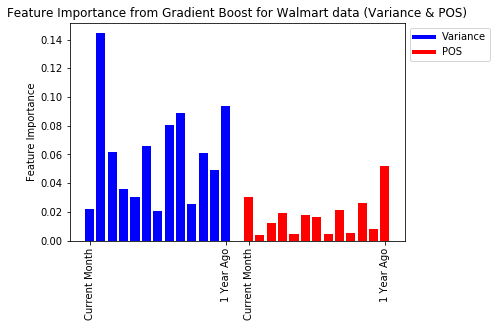

In [111]:
legend_elements = [Line2D([0], [0], color='b', lw=4, label='Variance'),
                   Line2D([0], [0], color='r', lw=4, label='POS')]
plt.bar(range(13), feature_importance[:13], color='b')# color=13*'b' + 13*'r')
plt.bar(range(14, 27), feature_importance[13:], color='r')
plt.xticks([0, 12, 14, 26], ['Current Month', '1 Year Ago', 'Current Month', '1 Year Ago'], rotation=90)
plt.ylabel('Feature Importance')
plt.title('Feature Importance from Gradient Boost for Walmart data (Variance & POS)')
plt.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(1,1))
# plt.savefig('Gboost_featureimportance.png', format='png')

In [ ]:
# model = Pipeline([
#         ('sampling', RandomOverSampler()),
#         ('clf', GradientBoostingClassifier())
#     ])

model_GB_v_p = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', GradientBoostingClassifier(learning_rate=0.075, max_depth=3, 
                                       min_samples_leaf=0.136, min_samples_split=0.354))
])

permutation_importance(model_GB_v_p, 100)

In [165]:
model_GB_v_p = Pipeline([
        ('sampling', RandomOverSampler()),
        ('clf', GradientBoostingClassifier())
    ])


model_GB_v_p.fit(X_train, np.argmax(y_train,1))

perm = PermutationImportance(model_GB_v_p, scoring='f1_macro').fit(X_test, np.argmax(y_test,1))
eli5.show_weights(perm, feature_names=['Var_Month'+ str(i) for i in range(0,13)] + ['POS_Month'+ str(i) for i in range(13)])

Weight,Feature
0.0778 ± 0.0248,Var_Month6
0.0664 ± 0.0045,Var_Month10
0.0618 ± 0.0432,Var_Month8
0.0509 ± 0.0722,POS_Month5
0.0427 ± 0.0694,POS_Month11
0.0421 ± 0.0588,Var_Month12
0.0410 ± 0.0769,POS_Month10
0.0392 ± 0.0520,Var_Month3
0.0336 ± 0.0277,POS_Month2
0.0315 ± 0.0455,Var_Month2


In [166]:
import shap
shap.initjs()

In [167]:
# model = Pipeline([
#         ('sampling', RandomOverSampler()),
#         ('clf', GradientBoostingClassifier(learning_rate=0.075, max_depth=8, 
#                                        min_samples_leaf=0.125, min_samples_split=0.4))
#     ])
# model.fit(X_train, np.argmax(y_train,1))

explainer = shap.KernelExplainer(model_GB_v_p.predict_proba, X_train)
shap_values = explainer.shap_values(X_test[0])
shap.force_plot(explainer.expected_value[0], shap_values[0], 
                ['Var_Month'+ str(i) for i in range(0,13)] + ['POS_Month'+ str(i) for i in range(13)])

Using 121 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


In [168]:
# single_shap_values = explainer.shap_values(X_inv_test[0])
# shap.force_plot(explainer.expected_value[0], single_shap_values[0], 
#                 ['Var_Month'+ str(i) for i in range(0,13)] + ['POS_Month'+ str(i) for i in range(13)])

In [169]:
shap.force_plot(explainer.expected_value[4], shap_values[4], 
                ['Var_Month'+ str(i) for i in range(0,13)] + ['POS_Month'+ str(i) for i in range(13)])





  0%|          | 0/58 [00:00<?, ?it/s]



  2%|▏         | 1/58 [00:03<03:22,  3.55s/it]



  3%|▎         | 2/58 [00:06<03:09,  3.39s/it]



  5%|▌         | 3/58 [00:09<03:00,  3.27s/it]



  7%|▋         | 4/58 [00:12<02:55,  3.24s/it]



  9%|▊         | 5/58 [00:15<02:47,  3.17s/it]



 10%|█         | 6/58 [00:19<02:47,  3.23s/it]



 12%|█▏        | 7/58 [00:22<02:43,  3.21s/it]



 14%|█▍        | 8/58 [00:25<02:37,  3.15s/it]



 16%|█▌        | 9/58 [00:28<02:39,  3.25s/it]



 17%|█▋        | 10/58 [00:32<02:38,  3.31s/it]



 19%|█▉        | 11/58 [00:35<02:37,  3.36s/it]



 21%|██        | 12/58 [00:39<02:36,  3.40s/it]



 22%|██▏       | 13/58 [00:42<02:34,  3.43s/it]



 24%|██▍       | 14/58 [00:46<02:31,  3.45s/it]



 26%|██▌       | 15/58 [00:49<02:24,  3.37s/it]



 28%|██▊       | 16/58 [00:52<02:23,  3.41s/it]



 29%|██▉       | 17/58 [00:56<02:17,  3.36s/it]



 31%|███       | 18/58 [00:59<02:16,  3.41s/it]



 33%|███▎      | 19/58 [01:03<02:14,  3.44s/i

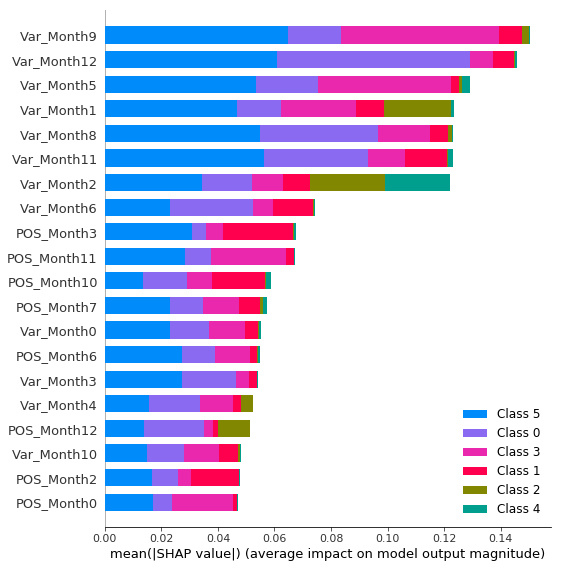

In [170]:
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, ['Var_Month'+ str(i) for i in range(0,13)] + ['POS_Month'+ str(i) for i in range(13)])
#it is shown as bargraph because we have multiple classes in the output

In [171]:
label_cols

['Promo', 'Phasing', 'SP&D', 'POS', 'Other', 'NoComm']

# <font color='red'>Multiclass classification VAR+POS+VAR</font>

In [172]:
X_inv = np.concatenate((BR_TR_timeseries_windows, monthly_pos_windows, monthly_inv_windows), axis=1)
X_inv_train, X_inv_test, y_inv_train, y_inv_test = train_test_split(X_inv, y, test_size=0.2, random_state=0)

In [173]:
#Multiclass classification (xtrain and ytrain as parameters)
def evaluate_model3(estimator, xtrain, xtest, ytrain, ytest, runs=10):
    
    metrics = ['precision_macro', 'precision_micro', 'recall_macro', 'recall_micro',
              'f1_macro', 'f1_micro', 'gms_macro', 'gms_micro']
    results = {m:[] for m in metrics}

    for _ in range(runs):
        model = estimator
        model.fit(xtrain, np.argmax(ytrain, 1))
        y_pred = model.predict(xtest)

        results['precision_macro'].append(precision_score(np.argmax(ytest,1), y_pred, average='macro'))
        results['precision_micro'].append(precision_score(np.argmax(ytest,1), y_pred, average='micro')) 
        results['recall_macro'].append(recall_score(np.argmax(ytest,1), y_pred, average='macro'))
        results['recall_micro'].append(recall_score(np.argmax(ytest,1), y_pred, average='micro'))
        results['f1_macro'].append(f1_score(np.argmax(ytest,1), y_pred, average='macro'))
        results['f1_micro'].append(f1_score(np.argmax(ytest,1), y_pred, average='micro'))
        results['gms_macro'].append(geometric_mean_score(np.argmax(ytest,1), y_pred, average='macro'))
        results['gms_micro'].append(geometric_mean_score(np.argmax(ytest,1), y_pred, average='micro'))
    
    return results

In [174]:
def permutation_importance3(estimator, xtrain, xtest, ytrain, ytest, runs=10):
    m = xtrain.shape[1]
    weights = np.zeros(m)
    std = np.zeros(m)
    for _ in range(runs):
        model = estimator
        model.fit(xtrain, np.argmax(ytrain,1))

        perm = PermutationImportance(model, scoring='f1_macro').fit(xtest, np.argmax(ytest, 1))
        df = eli5.format_as_dataframe(eli5.explain_weights(perm, top=m, feature_names=[str(i) for i in range(m)]))
        df['feature'] = pd.to_numeric(df['feature'])
        df.sort_values(by='feature', inplace=True)
        
        weights += df['weight'].values
        std += df['std'].values
        
    weights /= runs
    std /= runs
    features = ['Var_Month'+ str(i) for i in range(13)] +\
               ['POS_Month'+ str(i) for i in range(13)] +\
               ['Inv_Month'+ str(i) for i in range(13)]

    df_perm_importance = pd.DataFrame(data=np.vstack((weights, std)).T, columns=['weight', 'std'])
    df_perm_importance.insert(0, 'features', features)
    df_perm_importance.sort_values('weight', ascending=False, inplace=True)
    df_perm_importance.reset_index(drop=True, inplace=True)
    
    return df_perm_importance.style.apply(color_dataframe, axis=1)
    

## kNN with inv

In [175]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', KNeighborsClassifier())
])

# Grid search parameters
n_neighbors = list(range(1,6))

scorer = make_scorer(f1_score, average='macro')

param_grid = {'clf__n_neighbors':n_neighbors}

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

grid_search = grid.fit(X_inv_train, np.argmax(y_inv_train, axis=1))

In [176]:
grid_search.best_params_

{'clf__n_neighbors': 1}

In [177]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', KNeighborsClassifier(2))
])


results = evaluate_model3(model, X_inv_train, X_inv_test, y_inv_train, y_inv_test, 100)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.218
precision_micro 0.466
recall_macro 0.307
recall_micro 0.466
f1_macro 0.232
f1_micro 0.466
gms_macro 0.508
gms_micro 0.645


In [178]:
model.predict(X_inv_test)

array([5, 0, 5, 5, 5, 1, 5, 5, 1, 3, 5, 0, 3, 5, 5, 5, 0, 5, 5, 5, 1, 0,
       5, 0, 5, 1, 4, 5, 2, 5, 0, 0, 1, 5, 5, 0, 3, 5, 5, 0, 5, 5, 1, 5,
       5, 5, 5, 5, 5, 0, 5, 3, 5, 5, 5, 5, 3, 4])

In [179]:
np.argmax(y_inv_test, 1)

array([5, 5, 5, 5, 5, 1, 0, 5, 5, 5, 0, 5, 5, 5, 0, 0, 3, 5, 5, 5, 4, 3,
       5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 0, 3, 5, 3, 5, 5, 5, 1, 5,
       3, 3, 5, 3, 5, 5, 5, 5, 0, 5, 5, 3, 0, 5])

In [180]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', GradientBoostingClassifier(learning_rate=0.075, max_depth=5, 
                                       min_samples_leaf=0.173, min_samples_split=0.354))
])

permutation_importance3(model, X_inv_train, X_inv_test, y_inv_train, y_inv_test)

,features,weight,std
0,Var_Month1,0.0415245,0.015794
1,Var_Month5,0.0373535,0.0148394
2,Var_Month4,0.0306171,0.0154639
3,Var_Month8,0.0235883,0.016895
4,Inv_Month8,0.0194442,0.0143883
5,Inv_Month5,0.0165472,0.0161106
6,Var_Month12,0.00999125,0.0163658
7,POS_Month0,0.00693427,0.0078834
8,POS_Month7,0.00458424,0.00470671
9,Inv_Month12,0.00339863,0.00586257


## SVM with inv

In [190]:
if RUN_GRID_SEARCH:
    model = Pipeline([
        ('sampling', RandomOverSampler()),
        ('clf', SVC())
    ])

    # Grid search parameters
    Cs = [0.1, 1, 10, 20, 30, 40, 50]
    gammas = [0.001, 0.01, 0.1, 1]

    scorer = make_scorer(f1_score, average='macro')

    param_grid = {'clf__C':Cs, 'clf__gamma':gammas}

    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

    grid_search = grid.fit(X_inv_train, np.argmax(y_inv_train, axis=1))

In [191]:
if RUN_GRID_SEARCH:
    grid_search.best_params_

In [192]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', SVC(C=1, gamma=0.1))
])

results = evaluate_model3(model, X_inv_train, X_inv_test, y_inv_train, y_inv_test, 100)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.132
precision_micro 0.604
recall_macro 0.18
recall_micro 0.604
f1_macro 0.151
f1_micro 0.604
gms_macro 0.376
gms_micro 0.738


## Random Forest with inv

In [184]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', RandomForestClassifier())
])

# Grid search parameters
n_estimators = [10, 50, 100, 150, 200]
max_depth = [3, 5, 7, 9, 11, 13, 15, None]

scorer = make_scorer(f1_score, average='macro')

param_grid = {'clf__n_estimators':n_estimators, 'clf__max_depth':max_depth}

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

grid_search = grid.fit(X_inv_train, np.argmax(y_inv_train, axis=1))

In [185]:
grid_search.best_params_

{'clf__max_depth': 5, 'clf__n_estimators': 50}

In [186]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', RandomForestClassifier(100, max_depth=5))
])

results = evaluate_model3(model, X_inv_train, X_inv_test, y_inv_train, y_inv_test, 100)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.286
precision_micro 0.619
recall_macro 0.227
recall_micro 0.619
f1_macro 0.218
f1_micro 0.619
gms_macro 0.427
gms_micro 0.749


In [187]:
feature_importance = np.zeros(39)
for _ in range(100):
    model = Pipeline([
        ('sampling', RandomOverSampler()),
        ('clf', RandomForestClassifier(100, max_depth=5))
    ])
    model.fit(X_inv, np.argmax(y, 1))
    feature_importance += model.steps[1][1].feature_importances_
feature_importance /= 100    

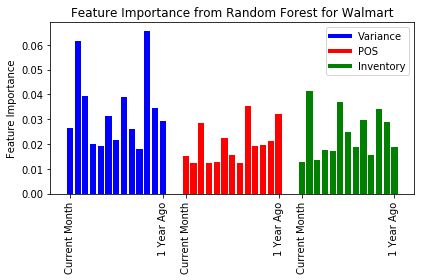

In [188]:
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='b', lw=4, label='Variance'),
                   Line2D([0], [0], color='r', lw=4, label='POS'),
                   Line2D([0], [0], color='g', lw=4, label='Inventory')]
plt.bar(range(13), feature_importance[:13], color='b')
plt.bar(range(15, 28), feature_importance[13:26], color='r')
plt.bar(range(30, 43), feature_importance[26:], color='g')
plt.xticks([0, 12, 15, 27, 30, 42], 
           ['Current Month', '1 Year Ago', 
            'Current Month', '1 Year Ago', 
            'Current Month', '1 Year Ago'], rotation=90)
plt.ylabel('Feature Importance')
plt.title('Feature Importance from Random Forest for Walmart')
plt.legend(handles=legend_elements, loc="best")
plt.tight_layout()
plt.savefig('RandomForest_featureimportance.png',format='png')

## Gradient Boost with inv

In [193]:
if RUN_GRID_SEARCH:
    model = Pipeline([
        ('sampling', RandomOverSampler()),
        ('clf', GradientBoostingClassifier())
    ])

    parameters = {
        "clf__learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
        "clf__min_samples_split": np.linspace(0.1, 0.5, 12),
        "clf__min_samples_leaf": np.linspace(0.1, 0.5, 12),
        "clf__max_depth":[3,5,8, None]
        }

    clf = GridSearchCV(model, parameters, scoring='f1_macro', cv=5, n_jobs=-1)
    clf.fit(X_inv_train, np.argmax(y_inv_train,1))
    clf.best_params_

In [194]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', GradientBoostingClassifier(learning_rate=0.075, max_depth=5, 
                                       min_samples_leaf=0.173, min_samples_split=0.354))
])

results = evaluate_model3(model, X_inv_train, X_inv_test, y_inv_train, y_inv_test, 100)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.265
precision_micro 0.632
recall_macro 0.215
recall_micro 0.632
f1_macro 0.208
f1_micro 0.632
gms_macro 0.416
gms_micro 0.757


In [195]:
feature_importance = np.zeros(39)
for _ in range(100):
    model = Pipeline([
        ('sampling', RandomOverSampler()),
        ('clf', GradientBoostingClassifier(learning_rate=0.075, max_depth=5, 
                                       min_samples_leaf=0.173, min_samples_split=0.354))
    ])
    model.fit(X_inv, np.argmax(y, 1))
    feature_importance += model.steps[1][1].feature_importances_
feature_importance /= 100

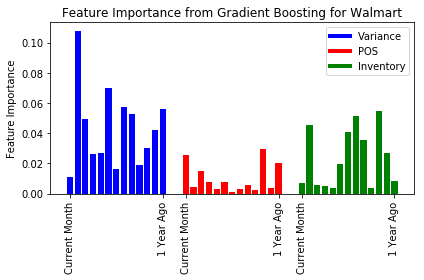

In [196]:
legend_elements = [Line2D([0], [0], color='b', lw=4, label='Variance'),
                   Line2D([0], [0], color='r', lw=4, label='POS'),
                   Line2D([0], [0], color='g', lw=4, label='Inventory')]
plt.bar(range(13), feature_importance[:13], color='b')
plt.bar(range(15, 28), feature_importance[13:26], color='r')
plt.bar(range(30, 43), feature_importance[26:], color='g')
plt.xticks([0, 12, 15, 27, 30, 42], 
           ['Current Month', '1 Year Ago', 
            'Current Month', '1 Year Ago', 
            'Current Month', '1 Year Ago'], rotation=90)

plt.ylabel('Feature Importance')
plt.title('Feature Importance from Gradient Boosting for Walmart')
plt.legend(handles=legend_elements, loc="best")
plt.tight_layout()
plt.savefig('Gboost_featureimportance.png', format='png')

## LSTM with inv

In [197]:
from utils import SplitAndReshape3

In [198]:
def create_model3(h1=100, h2=60, h3=60, dropout=0.2, recurrent_dropout=0.2):
    var_input = Input(shape=(WINDOW_SIZE, 1))
    var_lstm = LSTM(h1, dropout=dropout, recurrent_dropout=recurrent_dropout)
    var_output = var_lstm(var_input)

    pos_input = Input(shape=(WINDOW_SIZE, 1))
    pos_lstm = LSTM(h2, dropout=dropout, recurrent_dropout=recurrent_dropout)
    pos_output = pos_lstm(pos_input)
    
    inv_input = Input(shape=(WINDOW_SIZE, 1))
    inv_lstm = LSTM(h3, dropout=dropout, recurrent_dropout=recurrent_dropout)
    inv_output = inv_lstm(inv_input)

    merged = concatenate([var_output, pos_output, inv_output])
    classifier = Dense(6, activation='softmax')
    model_output = classifier(merged)

    model = Model([var_input, pos_input, inv_input], model_output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
    
    return model

In [200]:
import utils
model = Pipeline([
    ('sampling', RandomOverSampler()), 
    ('reshape', utils.SplitAndReshape3()),
    ('clf', KerasClassifier(create_model3, epochs=30, batch_size=16, verbose=1))
])

results = evaluate_model3(model, X_inv_train, X_inv_test, y_inv_train, y_inv_test, runs=5)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

1080/1080 [==============================] - 21s 19ms/step - loss: 1.6507
Epoch 2/30
1080/1080 [==============================] - 1s 1ms/step - loss: 1.4955
Epoch 3/30
1080/1080 [==============================] - 1s 1ms/step - loss: 1.4454
Epoch 4/30
1080/1080 [==============================] - 1s 1ms/step - loss: 1.3509
Epoch 5/30
1080/1080 [==============================] - 1s 1ms/step - loss: 1.3105
Epoch 6/30
1080/1080 [==============================] - 1s 1ms/step - loss: 1.2460
Epoch 7/30
1080/1080 [==============================] - 1s 1ms/step - loss: 1.1924
Epoch 8/30
1080/1080 [==============================] - 1s 1ms/step - loss: 1.1138
Epoch 9/30
1080/1080 [==============================] - 1s 1ms/step - loss: 1.0359
Epoch 10/30
1080/1080 [==============================] - 1s 1ms/step - loss: 1.0295
Epoch 11/30
1080/1080 [==============================] - 1s 1ms/step - loss: 0.9711
Epoch 12/30
1080/1080 [==============================] - 1s 1ms/step - loss: 0.9224
Epoch 13/3

 # <font color='red'>SHAP VAR+POS+INV</font>

## LSTM SHAP

In [204]:
# model = Pipeline([
#         ('sampling', RandomOverSampler()),
#         ('clf', RandomForestClassifier(100, max_depth=5))
#     ])

model = Pipeline([
    ('sampling', RandomOverSampler()), 
    ('reshape', utils.SplitAndReshape3()),
    ('clf', KerasClassifier(create_model3, epochs=60, batch_size=16, verbose=0))
])


model.fit(X_inv_train, np.argmax(y_inv_train,1))

Pipeline(memory=None,
     steps=[('sampling', RandomOverSampler(random_state=None, ratio=None, return_indices=False,
         sampling_strategy='auto')), ('reshape', <utils.SplitAndReshape3 object at 0x7f05ec6737b8>), ('clf', <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f05ec6737f0>)])

In [205]:
X_summary = shap.kmeans(X_inv_train, 50)
explainer = shap.KernelExplainer(model.predict_proba, X_summary)
shap_values = explainer.shap_values(X_inv_test)





  0%|          | 0/58 [00:00<?, ?it/s]



  2%|▏         | 1/58 [00:32<30:39, 32.27s/it]



  3%|▎         | 2/58 [01:04<29:59, 32.14s/it]



  5%|▌         | 3/58 [01:36<29:23, 32.07s/it]



  7%|▋         | 4/58 [02:07<28:47, 31.99s/it]



  9%|▊         | 5/58 [02:39<28:11, 31.91s/it]



 10%|█         | 6/58 [03:11<27:36, 31.85s/it]



 12%|█▏        | 7/58 [03:43<27:06, 31.89s/it]



 14%|█▍        | 8/58 [04:14<26:32, 31.85s/it]



 16%|█▌        | 9/58 [04:46<26:01, 31.86s/it]



 17%|█▋        | 10/58 [05:18<25:26, 31.81s/it]



 19%|█▉        | 11/58 [05:50<24:55, 31.83s/it]



 21%|██        | 12/58 [06:22<24:25, 31.86s/it]



 22%|██▏       | 13/58 [06:54<23:52, 31.84s/it]



 24%|██▍       | 14/58 [07:25<23:19, 31.80s/it]



 26%|██▌       | 15/58 [07:57<22:45, 31.76s/it]



 28%|██▊       | 16/58 [08:29<22:14, 31.78s/it]



 29%|██▉       | 17/58 [09:01<21:51, 31.99s/it]



 31%|███       | 18/58 [09:33<21:20, 32.01s/it]



 33%|███▎      | 19/58 [10:05<20:47, 31.99s/i

In [206]:
feature_names = ['Var_Month'+ str(i) for i in range(13)] +\
                ['POS_Month'+ str(i) for i in range(13)] +\
                ['Inv_Month'+ str(i) for i in range(13)]

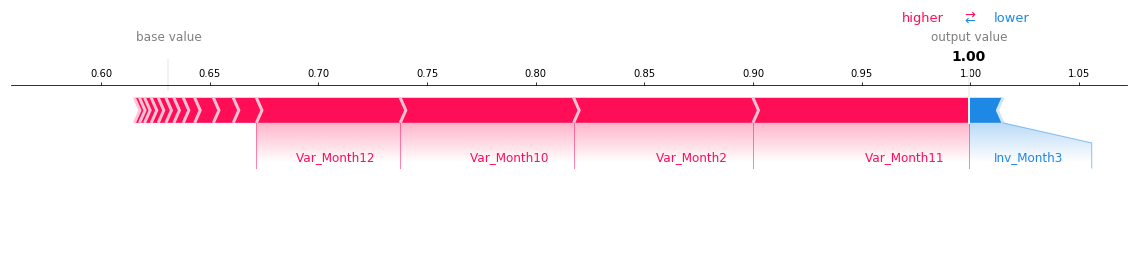

In [207]:
single_shap_values = explainer.shap_values(X_inv_test[0])
shap.force_plot(explainer.expected_value[5], single_shap_values[5], feature_names, matplotlib=True)

In [208]:
mean_shap_values = np.mean(np.abs(shap_values), axis=1)

In [209]:
shap_df = pd.DataFrame(mean_shap_values.T, columns=label_cols, index=feature_names)
shap_df.head()

,Promo,Phasing,SP&D,POS,Other,NoComm
Var_Month0,0.022439,0.026212,0.003893,0.019945,0.008085,0.044017
Var_Month1,0.015608,0.029556,0.004955,0.022990,0.007294,0.048468
Var_Month2,0.020704,0.033476,0.004478,0.028452,0.003363,0.058741
Var_Month3,0.022342,0.017032,0.005083,0.022337,0.002728,0.039824
Var_Month4,0.016522,0.021685,0.006688,0.026133,0.002175,0.034072


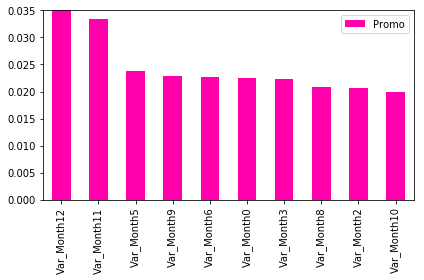

In [210]:
# shap_df.sort_values('Promo', ascending=False, inplace=True)
shap_df.sort_values('Promo', ascending=False)[:10].plot(kind='bar', y='Promo', ylim=(0,0.035), color='#FF00AA')
plt.tight_layout()
# plt.savefig('RFPromo.png', format='png')

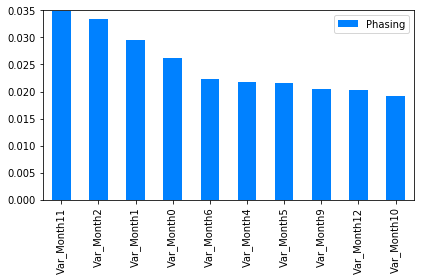

In [211]:
shap_df.sort_values('Phasing', ascending=False)[:10].plot(kind='bar', y='Phasing', color='#0081FF', ylim=(0,0.035))
plt.tight_layout()
# plt.savefig('RFPhasing.png', format='png')

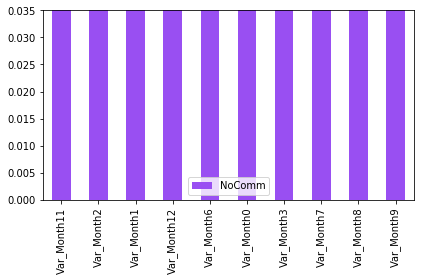

In [212]:
shap_df.sort_values('NoComm', ascending=False)[:10].plot(kind='bar', y='NoComm', color='#994FF2', ylim=(0,0.035))
plt.tight_layout()
# plt.savefig('RFNoComm.png', format='png')

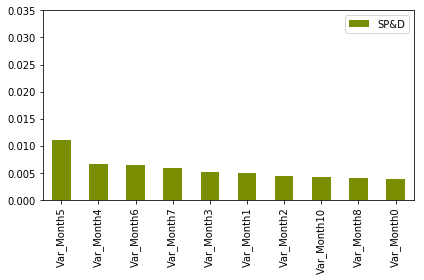

In [213]:
shap_df.sort_values('SP&D', ascending=False)[:10].plot(kind='bar', y='SP&D', color='#7A8C00', ylim=(0,0.035))
plt.tight_layout()
# plt.savefig('RF_SPnD.png', format='png')

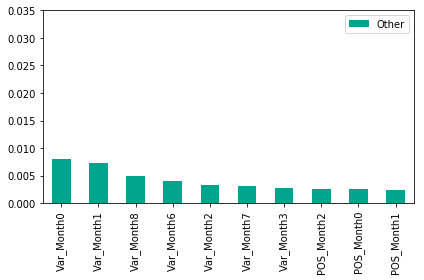

In [214]:
shap_df.sort_values('Other', ascending=False)[:10].plot(kind='bar', y='Other', color='#00A48F', ylim=(0,0.035))
plt.tight_layout()
# plt.savefig('RFOther.png', format='png')

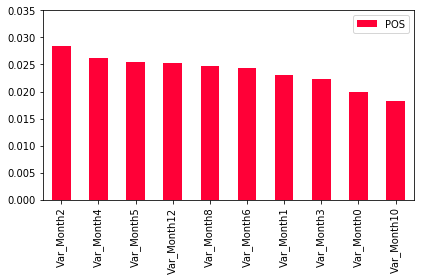

In [215]:
shap_df.sort_values('POS', ascending=False)[:10].plot(kind='bar', y='POS', color='#FF0037', ylim=(0,0.035))
plt.tight_layout()
# plt.savefig('RF_POS.png', format='png')

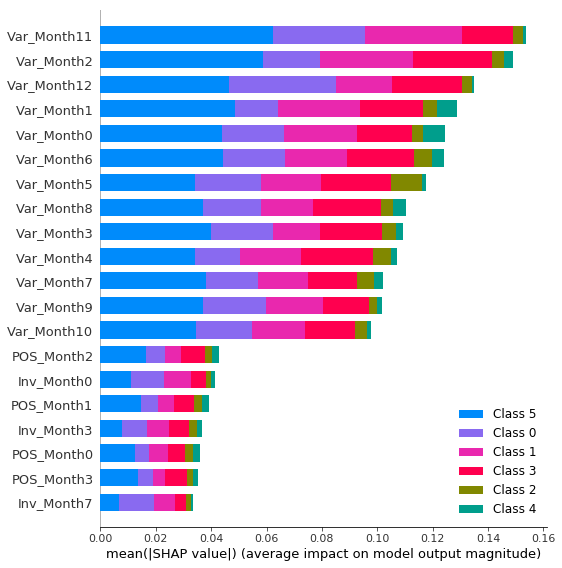

In [216]:
shap.summary_plot(shap_values, feature_names=feature_names, max_display=20)
# plt.savefig('RF_Summary.png', format='png')

## Random Forest SHAP

In [217]:
model = Pipeline([
        ('sampling', RandomOverSampler()),
        ('clf', RandomForestClassifier(100, max_depth=5))
    ])

model.fit(X_inv, np.argmax(y,1))

Pipeline(memory=None,
     steps=[('sampling', RandomOverSampler(random_state=None, ratio=None, return_indices=False,
         sampling_strategy='auto')), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impur...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [218]:
explainer = shap.KernelExplainer(model.predict_proba, X_inv)
shap_values = explainer.shap_values(X_inv)

Using 286 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.




  0%|          | 0/286 [00:00<?, ?it/s]



  0%|          | 1/286 [00:08<38:43,  8.15s/it]



  1%|          | 2/286 [00:16<38:26,  8.12s/it]



  1%|          | 3/286 [00:24<37:53,  8.03s/it]



  1%|▏         | 4/286 [00:32<38:05,  8.11s/it]



  2%|▏         | 5/286 [00:40<38:20,  8.19s/it]



  2%|▏         | 6/286 [00:48<37:36,  8.06s/it]



  2%|▏         | 7/286 [00:56<37:30,  8.07s/it]



  3%|▎         | 8/286 [01:04<37:26,  8.08s/it]



  3%|▎         | 9/286 [01:12<37:01,  8.02s/it]



  3%|▎         | 10/286 [01:20<36:51,  8.01s/it]



  4%|▍         | 11/286 [01:28<36:27,  7.96s/it]



  4%|▍         | 12/286 [01:36<36:23,  7.97s/it]



  5%|▍         | 13/286 [01:44<36:21,  7.99s/it]



  5%|▍         | 14/286 [01:52<36:14,  7.99s/it]



  5%|▌         | 15/286 [02:00<36:48,  8.15s/it]



  6%|▌         | 16/286 [02:08<

 88%|████████▊ | 251/286 [33:16<04:38,  7.95s/it]



 88%|████████▊ | 252/286 [33:24<04:28,  7.90s/it]



 88%|████████▊ | 253/286 [33:32<04:19,  7.86s/it]



 89%|████████▉ | 254/286 [33:40<04:14,  7.94s/it]



 89%|████████▉ | 255/286 [33:48<04:05,  7.91s/it]



 90%|████████▉ | 256/286 [33:56<03:56,  7.87s/it]



 90%|████████▉ | 257/286 [34:03<03:48,  7.89s/it]



 90%|█████████ | 258/286 [34:12<03:42,  7.94s/it]



 91%|█████████ | 259/286 [34:19<03:32,  7.88s/it]



 91%|█████████ | 260/286 [34:27<03:24,  7.87s/it]



 91%|█████████▏| 261/286 [34:35<03:16,  7.87s/it]



 92%|█████████▏| 262/286 [34:43<03:08,  7.83s/it]



 92%|█████████▏| 263/286 [34:51<03:02,  7.92s/it]



 92%|█████████▏| 264/286 [34:59<02:56,  8.04s/it]



 93%|█████████▎| 265/286 [35:07<02:47,  7.99s/it]



 93%|█████████▎| 266/286 [35:15<02:38,  7.92s/it]



 93%|█████████▎| 267/286 [35:22<02:29,  7.84s/it]



 94%|█████████▎| 268/286 [35:31<02:23,  7.98s/it]



 94%|█████████▍| 269/286 [35:39<02:14,  7.92s/

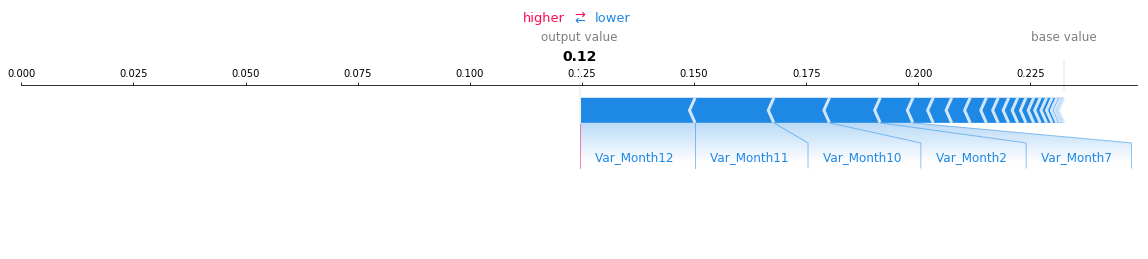

In [219]:
# single_shap_values = explainer.shap_values(X_inv_test[0])
shap.force_plot(explainer.expected_value[0], single_shap_values[0], feature_names, matplotlib=True)


In [220]:
mean_shap_values = np.mean(np.abs(shap_values), axis=1)

In [221]:
shap_df = pd.DataFrame(mean_shap_values.T, columns=label_cols, index=feature_names)
shap_df.head()

,Promo,Phasing,SP&D,POS,Other,NoComm
Var_Month0,0.002394,0.001657,0.000714,0.002279,0.002956,0.002764
Var_Month1,0.010554,0.032867,0.009290,0.027592,0.007068,0.008001
Var_Month2,0.003464,0.004074,0.008922,0.006430,0.003652,0.004747
Var_Month3,0.004743,0.001872,0.001316,0.005584,0.002233,0.002650
Var_Month4,0.003545,0.005289,0.002323,0.001145,0.001307,0.003664


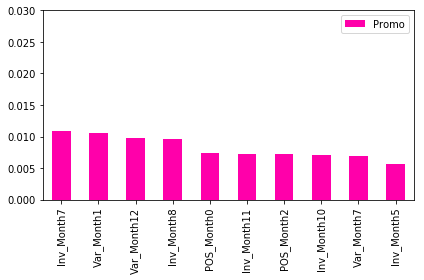

In [222]:
# shap_df.sort_values('Promo', ascending=False, inplace=True)
shap_df.sort_values('Promo', ascending=False)[:10].plot(kind='bar', y='Promo', ylim=(0,0.03), color='#FF00AA')
plt.tight_layout()
# plt.savefig('RFPromo.png', format='png')

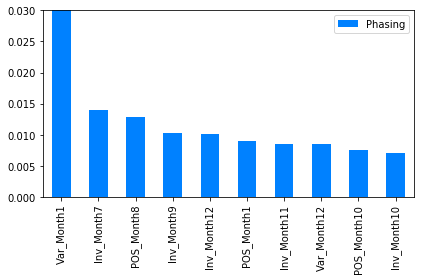

In [223]:
shap_df.sort_values('Phasing', ascending=False)[:10].plot(kind='bar', y='Phasing', color='#0081FF', ylim=(0,0.03))
plt.tight_layout()
# plt.savefig('RFPhasing.png', format='png')

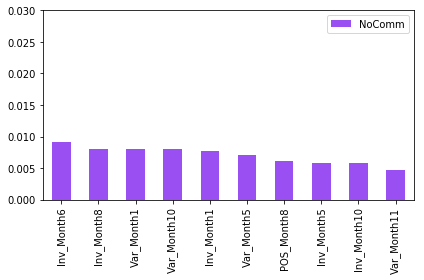

In [224]:
shap_df.sort_values('NoComm', ascending=False)[:10].plot(kind='bar', y='NoComm', color='#994FF2', ylim=(0,0.03))
plt.tight_layout()
# plt.savefig('RFNoComm.png', format='png')

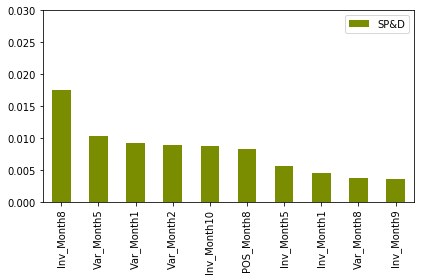

In [225]:
shap_df.sort_values('SP&D', ascending=False)[:10].plot(kind='bar', y='SP&D', color='#7A8C00', ylim=(0,0.03))
plt.tight_layout()
# plt.savefig('RF_SPnD.png', format='png')

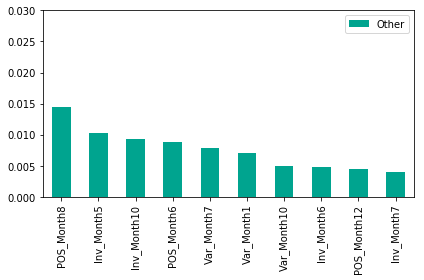

In [226]:
shap_df.sort_values('Other', ascending=False)[:10].plot(kind='bar', y='Other', color='#00A48F', ylim=(0,0.03))
plt.tight_layout()
# plt.savefig('RFOther.png', format='png')

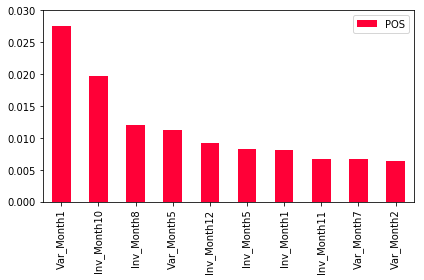

In [227]:
shap_df.sort_values('POS', ascending=False)[:10].plot(kind='bar', y='POS', color='#FF0037', ylim=(0,0.03))
plt.tight_layout()
# plt.savefig('RF_POS.png', format='png')

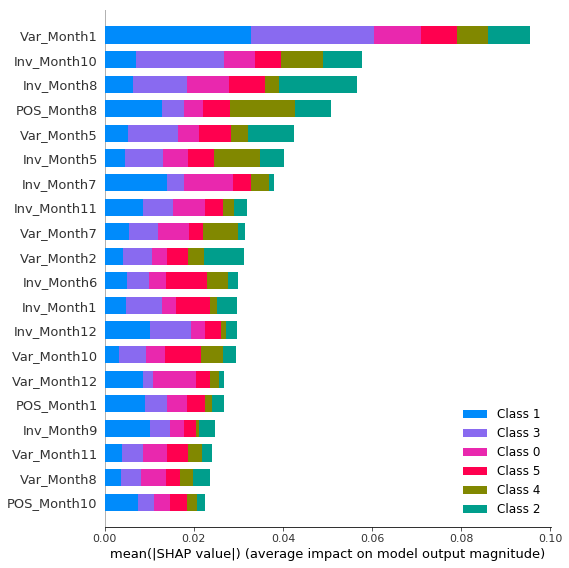

In [228]:
feature_names = ['Var_Month'+ str(i) for i in range(13)] +\
                ['POS_Month'+ str(i) for i in range(13)] +\
                ['Inv_Month'+ str(i) for i in range(13)]
shap.summary_plot(shap_values, feature_names=feature_names, max_display=20)
# plt.savefig('RF_Summary.png', format='png')

In [229]:
label_cols

['Promo', 'Phasing', 'SP&D', 'POS', 'Other', 'NoComm']

# <font color='red'>Multiclass classification VAR</font>

In [120]:
X_var = BR_TR_timeseries_windows[:]
X_var_train, X_var_test, y_var_train, y_var_test = train_test_split(X_var, y, test_size=0.2, random_state=0)

## kNN with var

In [230]:
if RUN_GRID_SEARCH:
    model = Pipeline([
        ('sampling', RandomOverSampler()),
        ('clf', KNeighborsClassifier())
    ])

    # Grid search parameters
    n_neighbors = list(range(1,6))

    scorer = make_scorer(f1_score, average='macro')

    param_grid = {'clf__n_neighbors':n_neighbors}

    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

    grid_search = grid.fit(X_var_train, np.argmax(y_var_train, axis=1))

In [231]:
if RUN_GRID_SEARCH:
    grid_search.best_params_

In [232]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', KNeighborsClassifier(1))
])


results = evaluate_model3(model, X_var_train, X_var_test, y_var_train, y_var_test, 100)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.497
precision_micro 0.672
recall_macro 0.335
recall_micro 0.672
f1_macro 0.34
f1_micro 0.672
gms_macro 0.531
gms_micro 0.786


In [233]:
from sklearn.dummy import DummyClassifier


In [234]:
model = Pipeline([
    ('clf', DummyClassifier(strategy='most_frequent'))
])


results = evaluate_model3(model, X_var_train, X_var_test, y_var_train, y_var_test, 100)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.134
precision_micro 0.672
recall_macro 0.2
recall_micro 0.672
f1_macro 0.161
f1_micro 0.672
gms_macro 0.4
gms_micro 0.786


In [235]:
model.predict(X_var_test)

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [236]:
np.argmax(y_var_test, 1)

array([5, 5, 5, 5, 5, 1, 0, 5, 5, 5, 0, 5, 5, 5, 0, 0, 3, 5, 5, 5, 4, 3,
       5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 0, 3, 5, 3, 5, 5, 5, 1, 5,
       3, 3, 5, 3, 5, 5, 5, 5, 0, 5, 5, 3, 0, 5])

## SVM with var

In [237]:
if RUN_GRID_SEARCH:
    model = Pipeline([
        ('sampling', RandomOverSampler()),
        ('clf', SVC())
    ])

    # Grid search parameters
    Cs = [0.1, 1, 10, 20, 30, 40, 50]
    gammas = [0.001, 0.01, 0.1, 1]

    scorer = make_scorer(f1_score, average='macro')

    param_grid = {'clf__C':Cs, 'clf__gamma':gammas}

    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

    grid_search = grid.fit(X_var_train, np.argmax(y_var_train, axis=1))

In [238]:
if RUN_GRID_SEARCH:
    grid_search.best_params_

In [239]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', SVC(C=10, gamma=1))
])

results = evaluate_model3(model, X_var_train, X_var_test, y_var_train, y_var_test, 100)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.13
precision_micro 0.613
recall_macro 0.182
recall_micro 0.613
f1_macro 0.152
f1_micro 0.613
gms_macro 0.378
gms_micro 0.744


## Random Forest with var

In [240]:
if RUN_GRID_SEARCH:
    model = Pipeline([
        ('sampling', RandomOverSampler()),
        ('clf', RandomForestClassifier())
    ])

    # Grid search parameters
    n_estimators = [10, 50, 100, 150, 200]
    max_depth = [3, 5, 7, 9, 11, 13, 15, None]

    scorer = make_scorer(f1_score, average='macro')

    param_grid = {'clf__n_estimators':n_estimators, 'clf__max_depth':max_depth}

    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

    grid_search = grid.fit(X_var_train, np.argmax(y_var_train, axis=1))

In [241]:
if RUN_GRID_SEARCH:
    grid_search.best_params_

In [242]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', RandomForestClassifier(200, max_depth=5))
])

results_rf_v = evaluate_model3(model, X_var_train, X_var_test, y_var_train, y_var_test, 100)
for metric, value in results_rf_v.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.218
precision_micro 0.661
recall_macro 0.217
recall_micro 0.661
f1_macro 0.204
f1_micro 0.661
gms_macro 0.423
gms_micro 0.779


In [243]:
feature_importance_rf_v = np.zeros(13)
for _ in range(100):
    model = Pipeline([
        ('sampling', RandomOverSampler()),
        ('clf', RandomForestClassifier(200, max_depth=5))
    ])
    model.fit(X_var, np.argmax(y, 1))
    feature_importance_rf_v += model.steps[1][1].feature_importances_
feature_importance_rf_v /= 100    

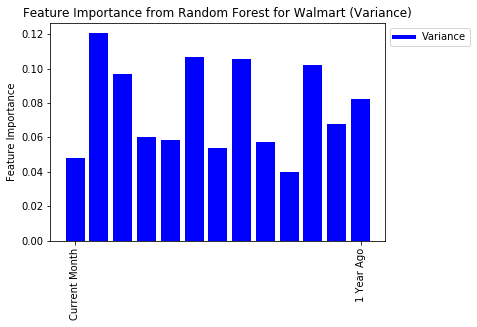

In [244]:
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='b', lw=4, label='Variance')]
plt.bar(range(13), feature_importance_rf_v[:13], color='b')
plt.xticks([0, 12], 
           ['Current Month', '1 Year Ago'], rotation=90)
plt.ylabel('Feature Importance')
plt.title('Feature Importance from Random Forest for Walmart (Variance)')
plt.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(1,1))
# plt.savefig('RandomForest_featureimportance.png',format='png')

## Gradient Boost with var

In [245]:
if RUN_GRID_SEARCH:
    model = Pipeline([
        ('sampling', RandomOverSampler()),
        ('clf', GradientBoostingClassifier())
    ])

    parameters = {
        "clf__learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
        "clf__min_samples_split": np.linspace(0.1, 0.5, 12),
        "clf__min_samples_leaf": np.linspace(0.1, 0.5, 12),
        "clf__max_depth":[3,5,8, None]
        }

    clf = GridSearchCV(model, parameters, scoring='f1_macro', cv=5, n_jobs=-1)
    clf.fit(X_var_train, np.argmax(y_var_train,1))
    clf.best_params_

In [246]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', GradientBoostingClassifier(learning_rate=0.025, max_depth=8, 
                                       min_samples_leaf=0.1, min_samples_split=0.136))
])

results_GB_v = evaluate_model3(model, X_var_train, X_var_test, y_var_train, y_var_test, 100)
for metric, value in results_GB_v.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.212
precision_micro 0.547
recall_macro 0.178
recall_micro 0.547
f1_macro 0.184
f1_micro 0.547
gms_macro 0.384
gms_micro 0.702


In [247]:
feature_importance_GB_v = np.zeros(13)
for _ in range(100):
    model = Pipeline([
        ('sampling', RandomOverSampler()),
        ('clf', GradientBoostingClassifier(learning_rate=0.025, max_depth=8, 
                                       min_samples_leaf=0.1, min_samples_split=0.136))
    ])
    model.fit(X_var, np.argmax(y, 1))
    feature_importance_GB_v += model.steps[1][1].feature_importances_
feature_importance_GB_v /= 100

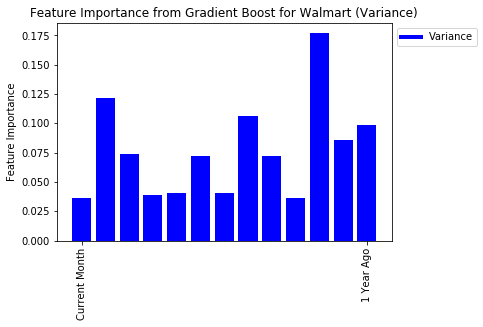

In [248]:
legend_elements = [Line2D([0], [0], color='b', lw=4, label='Variance')]
plt.bar(range(13), feature_importance_GB_v[:13], color='b')
plt.xticks([0, 12], 
           ['Current Month', '1 Year Ago'], rotation=90)

plt.ylabel('Feature Importance')
plt.title('Feature Importance from Gradient Boost for Walmart (Variance)')
plt.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(1,1))
# plt.savefig('Gboost_featureimportance.png', format='png')

## LSTM with var

In [249]:
from utils import SplitAndReshape3

In [250]:
def create_model1(h1=100, dropout=0.2, recurrent_dropout=0.2):
    var_input = Input(shape=(WINDOW_SIZE, 1))
    var_lstm = LSTM(h1, dropout=dropout, recurrent_dropout=recurrent_dropout)
    var_output = var_lstm(var_input)

    classifier = Dense(6, activation='softmax')
    model_output = classifier(var_output)

    model = Model(var_input, model_output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
    
    return model

In [251]:
model = Pipeline([
    ('sampling', RandomOverSampler()), 
    ('reshape', Reshape()),
    ('clf', KerasClassifier(create_model1, epochs=60, batch_size=16, verbose=0))
])

results_lstm_v = evaluate_model3(model, X_var_train, X_var_test, y_var_train, y_var_test, runs=5)
for metric, value in results_lstm_v.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.198
precision_micro 0.559
recall_macro 0.187
recall_micro 0.559
f1_macro 0.187
f1_micro 0.559
gms_macro 0.391
gms_micro 0.71


# <font color='red'>Binary classification VAR</font>

(array([ 30.,   0.,  11.,   0.,   4.,   0.,  19.,   0.,   3., 219.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

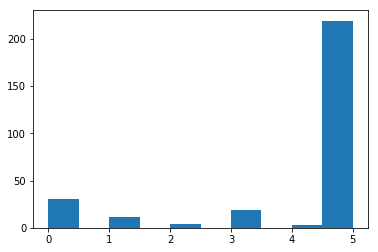

In [117]:
plt.hist(np.argmax(y,1))

In [121]:
y_var_train[:,5]

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0])

In [122]:
# yb_var_train = [[1-i[5],i[5]] for i in y_var_train]
# yb_var_test = [[1-i[5],i[5]] for i in y_var_test]

yb_var_train = y_var_train[:,5]
yb_var_test = y_var_test[:,5]

In [124]:
#Binary classification
def evaluate_model4(estimator, xtrain, xtest, ytrain, ytest, runs=10):
    
    metrics = ['precision_macro', 'precision_micro', 'recall_macro', 'recall_micro',
              'f1_macro', 'f1_micro', 'gms_macro', 'gms_micro']
    results = {m:[] for m in metrics}

    for _ in range(runs):
        model = estimator
        model.fit(xtrain, ytrain)
        y_pred = model.predict(xtest)

        results['precision_macro'].append(precision_score(ytest, y_pred, average='macro'))
        results['precision_micro'].append(precision_score(ytest, y_pred, average='micro')) 
        results['recall_macro'].append(recall_score(ytest, y_pred, average='macro'))
        results['recall_micro'].append(recall_score(ytest, y_pred, average='micro'))
        results['f1_macro'].append(f1_score(ytest, y_pred, average='macro'))
        results['f1_micro'].append(f1_score(ytest, y_pred, average='micro'))
        results['gms_macro'].append(geometric_mean_score(ytest, y_pred, average='macro'))
        results['gms_micro'].append(geometric_mean_score(ytest, y_pred, average='micro'))
    
    return results

In [140]:
def get_shap_plot_summary(model, X, feature_names, plotsummary=False):
    X_summary = shap.kmeans(X, 50)
    explainer = shap.KernelExplainer(model.predict_proba, X_summary)
    shap_values = explainer.shap_values(X)
    if plotsummary:
        shap.summary_plot(shap_values[1], X, feature_names=feature_names)
    return (explainer, shap_values)

def shap_plot_summary(shap_values, X, feature_names, SaveEPS=False, epsfile='name.eps'):
    fig = shap.summary_plot(shap_values[1], X, feature_names=feature_names)
    if SaveEPS:
       plt.savefig(epsfile, format='eps', dpi=600) 
    return fig

## kNN

In [162]:
model_knnb_v = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', KNeighborsClassifier(1))
])

In [163]:
results_knnb_v = evaluate_model4(model_knnb_v, X_var_train, X_var_test, yb_var_train, yb_var_test, 100)
for metric, value in results_knnb_v.items():
    print(metric,'\t', np.round(np.mean(value), 3))

precision_macro 	 0.701
precision_micro 	 0.724
recall_macro 	 0.619
recall_micro 	 0.724
f1_macro 	 0.623
f1_micro 	 0.724
gms_macro 	 0.619
gms_micro 	 0.724







  0%|          | 0/286 [00:00<?, ?it/s]




  0%|          | 1/286 [00:01<05:05,  1.07s/it]




  1%|          | 2/286 [00:02<05:07,  1.08s/it]




  1%|          | 3/286 [00:03<05:07,  1.09s/it]




  1%|▏         | 4/286 [00:04<05:08,  1.09s/it]




  2%|▏         | 5/286 [00:05<05:08,  1.10s/it]




  2%|▏         | 6/286 [00:06<05:11,  1.11s/it]




  2%|▏         | 7/286 [00:07<05:09,  1.11s/it]




  3%|▎         | 8/286 [00:08<05:08,  1.11s/it]




  3%|▎         | 9/286 [00:10<05:12,  1.13s/it]




  3%|▎         | 10/286 [00:11<05:08,  1.12s/it]




  4%|▍         | 11/286 [00:12<05:03,  1.10s/it]




  4%|▍         | 12/286 [00:13<05:01,  1.10s/it]




  5%|▍         | 13/286 [00:14<05:03,  1.11s/it]




  5%|▍         | 14/286 [00:15<05:03,  1.12s/it]




  5%|▌         | 15/286 [00:16<05:03,  1.12s/it]




  6%|▌         | 16/286 [00:17<05:01,  1.12s/it]




  6%|▌         | 17/286 [00:18<05:01,  1.12s/it]




  6%|▋         | 18/286 [00:19<04:56,  1.11s/it]




  7%|▋

 83%|████████▎ | 238/286 [04:23<00:51,  1.08s/it]




 84%|████████▎ | 239/286 [04:24<00:50,  1.07s/it]




 84%|████████▍ | 240/286 [04:25<00:50,  1.10s/it]




 84%|████████▍ | 241/286 [04:26<00:49,  1.10s/it]




 85%|████████▍ | 242/286 [04:27<00:48,  1.10s/it]




 85%|████████▍ | 243/286 [04:28<00:46,  1.09s/it]




 85%|████████▌ | 244/286 [04:29<00:45,  1.10s/it]




 86%|████████▌ | 245/286 [04:30<00:45,  1.10s/it]




 86%|████████▌ | 246/286 [04:31<00:44,  1.10s/it]




 86%|████████▋ | 247/286 [04:33<00:42,  1.10s/it]




 87%|████████▋ | 248/286 [04:33<00:39,  1.05s/it]




 87%|████████▋ | 249/286 [04:35<00:39,  1.06s/it]




 87%|████████▋ | 250/286 [04:36<00:38,  1.06s/it]




 88%|████████▊ | 251/286 [04:37<00:36,  1.04s/it]




 88%|████████▊ | 252/286 [04:38<00:35,  1.04s/it]




 88%|████████▊ | 253/286 [04:39<00:35,  1.06s/it]




 89%|████████▉ | 254/286 [04:40<00:34,  1.08s/it]




 89%|████████▉ | 255/286 [04:41<00:33,  1.07s/it]




 90%|████████▉ | 256/286 [04

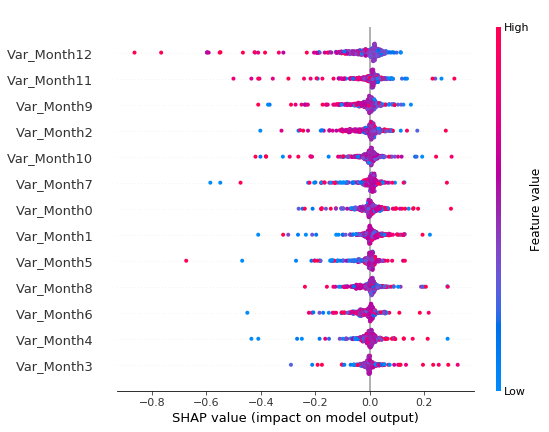

In [254]:
explainer_knnb_v, shap_values_knnb_v = get_shap_plot_summary(model_knnb_v, X_var, feature_names, True)

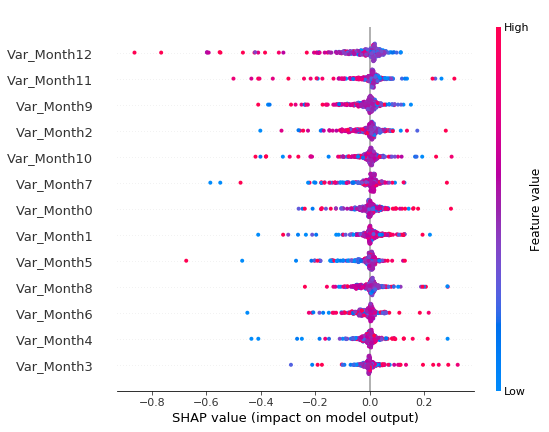

In [255]:
shap.summary_plot(shap_values_knnb_v[1], X_var, feature_names=feature_names, show=False)

## SVM

In [256]:
model_svmb_v = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', SVC(C=10, gamma=0.1, probability=True))
])

In [257]:
results_svmb_v = evaluate_model4(model_svmb_v, X_var_train, X_var_test, yb_var_train, yb_var_test, 100)
for metric, value in results_svmb_v.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.706
precision_micro 0.714
recall_macro 0.59
recall_micro 0.714
f1_macro 0.581
f1_micro 0.714
gms_macro 0.59
gms_micro 0.714


In [258]:
explainer_svmb_v, shap_values_svmb_v = get_shap_plot_summary(model_svmb_v, X_var, feature_names)






  0%|          | 0/286 [00:00<?, ?it/s]




  0%|          | 1/286 [00:01<06:16,  1.32s/it]




  1%|          | 2/286 [00:02<06:17,  1.33s/it]




  1%|          | 3/286 [00:04<06:17,  1.34s/it]




  1%|▏         | 4/286 [00:05<06:17,  1.34s/it]




  2%|▏         | 5/286 [00:06<06:16,  1.34s/it]




  2%|▏         | 6/286 [00:08<06:14,  1.34s/it]




  2%|▏         | 7/286 [00:09<06:15,  1.35s/it]




  3%|▎         | 8/286 [00:10<06:13,  1.34s/it]




  3%|▎         | 9/286 [00:12<06:12,  1.34s/it]




  3%|▎         | 10/286 [00:13<06:11,  1.34s/it]




  4%|▍         | 11/286 [00:14<06:09,  1.34s/it]




  4%|▍         | 12/286 [00:16<06:07,  1.34s/it]




  5%|▍         | 13/286 [00:17<06:06,  1.34s/it]




  5%|▍         | 14/286 [00:18<06:05,  1.34s/it]




  5%|▌         | 15/286 [00:20<06:04,  1.34s/it]




  6%|▌         | 16/286 [00:21<06:02,  1.34s/it]




  6%|▌         | 17/286 [00:22<05:59,  1.34s/it]




  6%|▋         | 18/286 [00:24<05:58,  1.34s/it]




  7%|▋

 83%|████████▎ | 238/286 [05:18<01:04,  1.34s/it]




 84%|████████▎ | 239/286 [05:20<01:03,  1.34s/it]




 84%|████████▍ | 240/286 [05:21<01:01,  1.34s/it]




 84%|████████▍ | 241/286 [05:22<00:59,  1.33s/it]




 85%|████████▍ | 242/286 [05:24<00:58,  1.33s/it]




 85%|████████▍ | 243/286 [05:25<00:57,  1.33s/it]




 85%|████████▌ | 244/286 [05:26<00:55,  1.33s/it]




 86%|████████▌ | 245/286 [05:28<00:54,  1.33s/it]




 86%|████████▌ | 246/286 [05:29<00:53,  1.33s/it]




 86%|████████▋ | 247/286 [05:30<00:51,  1.33s/it]




 87%|████████▋ | 248/286 [05:32<00:50,  1.32s/it]




 87%|████████▋ | 249/286 [05:33<00:49,  1.33s/it]




 87%|████████▋ | 250/286 [05:34<00:49,  1.37s/it]




 88%|████████▊ | 251/286 [05:36<00:47,  1.36s/it]




 88%|████████▊ | 252/286 [05:37<00:46,  1.36s/it]




 88%|████████▊ | 253/286 [05:38<00:44,  1.35s/it]




 89%|████████▉ | 254/286 [05:40<00:43,  1.35s/it]




 89%|████████▉ | 255/286 [05:41<00:41,  1.34s/it]




 90%|████████▉ | 256/286 [05

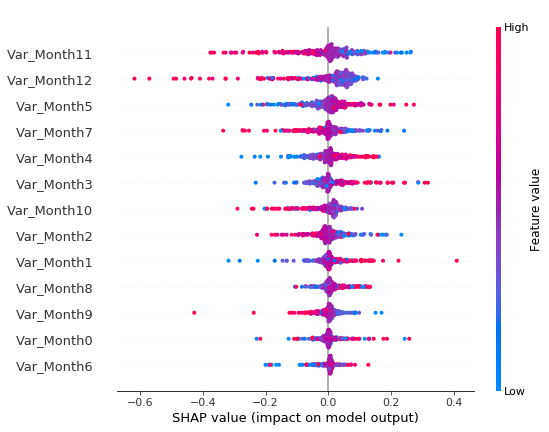

In [259]:
shap_plot_summary(shap_values_svmb_v, X_var, feature_names)

## XGBoost

In [260]:
model_GBb_v = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', GradientBoostingClassifier(learning_rate=0.025, max_depth=8, 
                                       min_samples_leaf=0.1, min_samples_split=0.136))
])

In [261]:
results_GBb_v = evaluate_model4(model_GBb_v, X_var_train, X_var_test, yb_var_train, yb_var_test, 100)
for metric, value in results_GBb_v.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.598
precision_micro 0.67
recall_macro 0.557
recall_micro 0.67
f1_macro 0.547
f1_micro 0.67
gms_macro 0.557
gms_micro 0.67


In [262]:
explainer_GBb_v, shap_values_GBb_v = get_shap_plot_summary(model_GBb_v, X_var, feature_names)






  0%|          | 0/286 [00:00<?, ?it/s]




  0%|          | 1/286 [00:00<02:31,  1.88it/s]




  1%|          | 2/286 [00:01<02:32,  1.86it/s]




  1%|          | 3/286 [00:01<02:33,  1.84it/s]




  1%|▏         | 4/286 [00:02<02:33,  1.83it/s]




  2%|▏         | 5/286 [00:02<02:33,  1.83it/s]




  2%|▏         | 6/286 [00:03<02:33,  1.82it/s]




  2%|▏         | 7/286 [00:03<02:33,  1.82it/s]




  3%|▎         | 8/286 [00:04<02:33,  1.81it/s]




  3%|▎         | 9/286 [00:05<02:38,  1.75it/s]




  3%|▎         | 10/286 [00:05<02:41,  1.71it/s]




  4%|▍         | 11/286 [00:06<02:42,  1.69it/s]




  4%|▍         | 12/286 [00:06<02:44,  1.66it/s]




  5%|▍         | 13/286 [00:07<02:44,  1.66it/s]




  5%|▍         | 14/286 [00:08<02:45,  1.64it/s]




  5%|▌         | 15/286 [00:08<02:45,  1.64it/s]




  6%|▌         | 16/286 [00:09<02:45,  1.63it/s]




  6%|▌         | 17/286 [00:09<02:44,  1.63it/s]




  6%|▋         | 18/286 [00:10<02:45,  1.62it/s]




  7%|▋

 83%|████████▎ | 238/286 [02:16<00:26,  1.82it/s]




 84%|████████▎ | 239/286 [02:16<00:25,  1.83it/s]




 84%|████████▍ | 240/286 [02:17<00:25,  1.82it/s]




 84%|████████▍ | 241/286 [02:17<00:24,  1.81it/s]




 85%|████████▍ | 242/286 [02:18<00:24,  1.79it/s]




 85%|████████▍ | 243/286 [02:18<00:23,  1.80it/s]




 85%|████████▌ | 244/286 [02:19<00:23,  1.79it/s]




 86%|████████▌ | 245/286 [02:20<00:22,  1.79it/s]




 86%|████████▌ | 246/286 [02:20<00:22,  1.80it/s]




 86%|████████▋ | 247/286 [02:21<00:21,  1.80it/s]




 87%|████████▋ | 248/286 [02:21<00:20,  1.83it/s]




 87%|████████▋ | 249/286 [02:22<00:20,  1.82it/s]




 87%|████████▋ | 250/286 [02:22<00:19,  1.82it/s]




 88%|████████▊ | 251/286 [02:23<00:19,  1.81it/s]




 88%|████████▊ | 252/286 [02:23<00:18,  1.81it/s]




 88%|████████▊ | 253/286 [02:24<00:18,  1.81it/s]




 89%|████████▉ | 254/286 [02:25<00:17,  1.81it/s]




 89%|████████▉ | 255/286 [02:25<00:17,  1.80it/s]




 90%|████████▉ | 256/286 [02

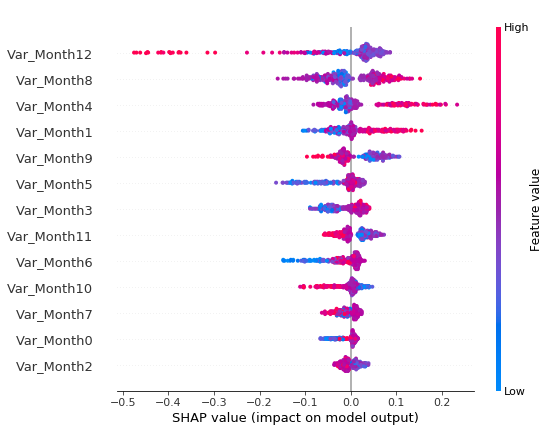

In [263]:
shap_plot_summary(shap_values_GBb_v, X_var, feature_names)

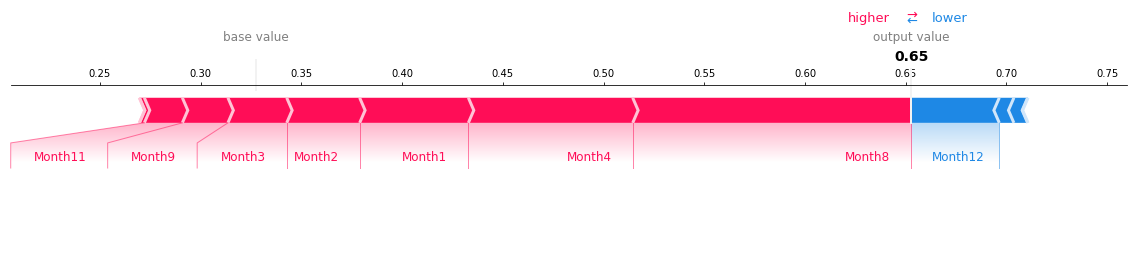

In [264]:
feature_names = ['Month'+ str(i) for i in range(13)]
single_shap_values = explainer_GBb_v.shap_values(X_var[31])
shap.force_plot(explainer_GBb_v.expected_value[0], single_shap_values[0], feature_names, matplotlib=True)

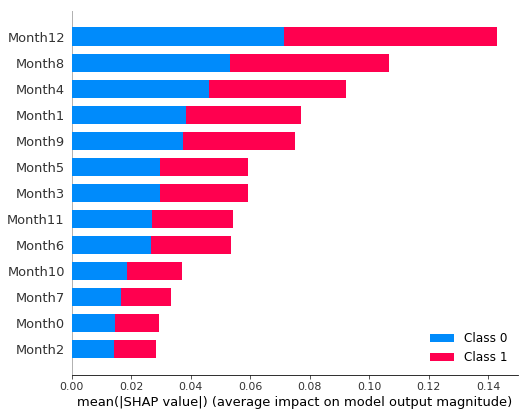

In [265]:
shap.summary_plot(shap_values_GBb_v, feature_names=feature_names, max_display=20)

In [266]:
X_summary = shap.kmeans(X_var, 50)
explainer_GBb_v_all = shap.KernelExplainer(model_GBb_v.predict_proba, X_summary)
shap_values_GBb_v_all = explainer_GBb_v_all.shap_values(X_var)






  0%|          | 0/286 [00:00<?, ?it/s]




  0%|          | 1/286 [00:00<02:27,  1.93it/s]




  1%|          | 2/286 [00:01<02:29,  1.90it/s]




  1%|          | 3/286 [00:01<02:32,  1.86it/s]




  1%|▏         | 4/286 [00:02<02:31,  1.86it/s]




  2%|▏         | 5/286 [00:02<02:31,  1.85it/s]




  2%|▏         | 6/286 [00:03<02:32,  1.84it/s]




  2%|▏         | 7/286 [00:03<02:31,  1.84it/s]




  3%|▎         | 8/286 [00:04<02:32,  1.82it/s]




  3%|▎         | 9/286 [00:04<02:32,  1.82it/s]




  3%|▎         | 10/286 [00:05<02:31,  1.83it/s]




  4%|▍         | 11/286 [00:06<02:30,  1.83it/s]




  4%|▍         | 12/286 [00:06<02:31,  1.81it/s]




  5%|▍         | 13/286 [00:07<02:31,  1.81it/s]




  5%|▍         | 14/286 [00:07<02:29,  1.83it/s]




  5%|▌         | 15/286 [00:08<02:30,  1.81it/s]




  6%|▌         | 16/286 [00:08<02:29,  1.81it/s]




  6%|▌         | 17/286 [00:09<02:27,  1.82it/s]




  6%|▋         | 18/286 [00:09<02:28,  1.81it/s]




  7%|▋

 83%|████████▎ | 238/286 [02:12<00:27,  1.78it/s]




 84%|████████▎ | 239/286 [02:13<00:26,  1.78it/s]




 84%|████████▍ | 240/286 [02:13<00:25,  1.78it/s]




 84%|████████▍ | 241/286 [02:14<00:25,  1.79it/s]




 85%|████████▍ | 242/286 [02:14<00:24,  1.79it/s]




 85%|████████▍ | 243/286 [02:15<00:23,  1.82it/s]




 85%|████████▌ | 244/286 [02:15<00:23,  1.82it/s]




 86%|████████▌ | 245/286 [02:16<00:22,  1.81it/s]




 86%|████████▌ | 246/286 [02:17<00:22,  1.81it/s]




 86%|████████▋ | 247/286 [02:17<00:21,  1.81it/s]




 87%|████████▋ | 248/286 [02:18<00:20,  1.81it/s]




 87%|████████▋ | 249/286 [02:18<00:20,  1.79it/s]




 87%|████████▋ | 250/286 [02:19<00:20,  1.79it/s]




 88%|████████▊ | 251/286 [02:19<00:19,  1.80it/s]




 88%|████████▊ | 252/286 [02:20<00:19,  1.78it/s]




 88%|████████▊ | 253/286 [02:20<00:18,  1.81it/s]




 89%|████████▉ | 254/286 [02:21<00:17,  1.81it/s]




 89%|████████▉ | 255/286 [02:22<00:17,  1.80it/s]




 90%|████████▉ | 256/286 [02

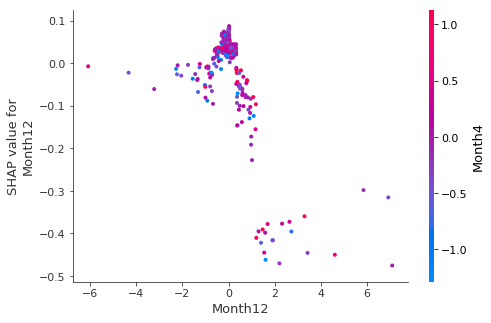

In [594]:
shap.dependence_plot('Month12', shap_values_GBb_v_all[1], X_var, interaction_index="Month4", 
                     feature_names=feature_names)

In [268]:
# X_summary = shap.kmeans(X_var, 50)
explainer_GBb_tree = shap.TreeExplainer(model_GBb_v.steps[1][1], X_var)
shap_values_GBb_tree = explainer_GBb_tree.shap_values(X_var)

In [269]:
#For info: how to access the model in pipeline
#model_GBb_v.steps[1][1].predict(X_var_train) - model_GBb_v.predict(X_var_train)

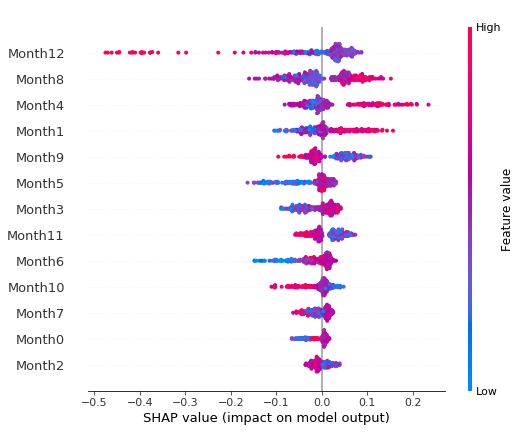

In [270]:
shap.summary_plot(shap_values_GBb_v_all[1], X_var, feature_names=feature_names, plot_type="dot")

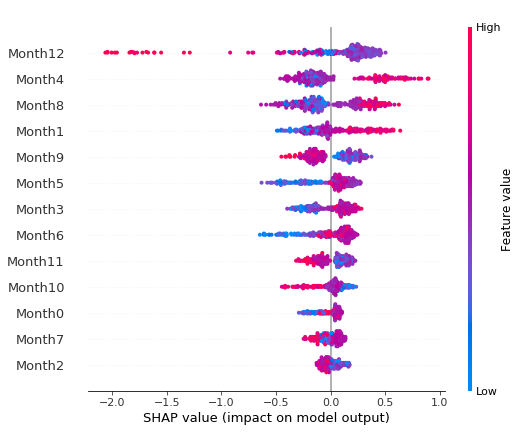

In [271]:
shap.summary_plot(shap_values_GBb_tree, X_var, feature_names=feature_names, plot_type="dot")  #there is only one output in prediction

## Random forest

In [272]:
model_rfb = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', RandomForestClassifier(200, max_depth=5))
])

results_rfb_v = evaluate_model4(model_rfb, X_var_train, X_var_test, yb_var_train, yb_var_test, 100)
for metric, value in results_rfb_v.items():
    print(metric, np.round(np.mean(value), 3))


precision_macro 0.13
precision_micro 0.613
recall_macro 0.182
recall_micro 0.613
f1_macro 0.152
f1_micro 0.613
gms_macro 0.378
gms_micro 0.744


In [273]:
X_summary = shap.kmeans(X_var, 50)   #Karim: note the use of Kmeans here (put in the article)
explainer_rfb = shap.KernelExplainer(model_rfb.predict_proba, X_summary)
shap_values_rfb_v = explainer_rfb.shap_values(X_var)






  0%|          | 0/286 [00:00<?, ?it/s]




  0%|          | 1/286 [00:01<07:13,  1.52s/it]




  1%|          | 2/286 [00:03<07:16,  1.54s/it]




  1%|          | 3/286 [00:04<07:14,  1.54s/it]




  1%|▏         | 4/286 [00:06<07:14,  1.54s/it]




  2%|▏         | 5/286 [00:07<07:14,  1.55s/it]




  2%|▏         | 6/286 [00:09<07:13,  1.55s/it]




  2%|▏         | 7/286 [00:10<07:11,  1.55s/it]




  3%|▎         | 8/286 [00:12<07:10,  1.55s/it]




  3%|▎         | 9/286 [00:13<07:07,  1.54s/it]




  3%|▎         | 10/286 [00:15<07:06,  1.55s/it]




  4%|▍         | 11/286 [00:17<07:04,  1.55s/it]




  4%|▍         | 12/286 [00:18<07:03,  1.55s/it]




  5%|▍         | 13/286 [00:20<07:02,  1.55s/it]




  5%|▍         | 14/286 [00:21<06:59,  1.54s/it]




  5%|▌         | 15/286 [00:23<06:58,  1.54s/it]




  6%|▌         | 16/286 [00:24<06:57,  1.55s/it]




  6%|▌         | 17/286 [00:26<06:55,  1.54s/it]




  6%|▋         | 18/286 [00:27<06:53,  1.54s/it]




  7%|▋

 83%|████████▎ | 238/286 [06:12<01:16,  1.60s/it]




 84%|████████▎ | 239/286 [06:13<01:15,  1.61s/it]




 84%|████████▍ | 240/286 [06:15<01:13,  1.60s/it]




 84%|████████▍ | 241/286 [06:17<01:12,  1.61s/it]




 85%|████████▍ | 242/286 [06:18<01:10,  1.61s/it]




 85%|████████▍ | 243/286 [06:20<01:09,  1.61s/it]




 85%|████████▌ | 244/286 [06:21<01:07,  1.61s/it]




 86%|████████▌ | 245/286 [06:23<01:06,  1.61s/it]




 86%|████████▌ | 246/286 [06:25<01:04,  1.61s/it]




 86%|████████▋ | 247/286 [06:26<01:02,  1.60s/it]




 87%|████████▋ | 248/286 [06:28<00:59,  1.58s/it]




 87%|████████▋ | 249/286 [06:29<00:58,  1.59s/it]




 87%|████████▋ | 250/286 [06:31<00:57,  1.59s/it]




 88%|████████▊ | 251/286 [06:33<00:56,  1.60s/it]




 88%|████████▊ | 252/286 [06:34<00:54,  1.61s/it]




 88%|████████▊ | 253/286 [06:36<00:53,  1.61s/it]




 89%|████████▉ | 254/286 [06:37<00:51,  1.61s/it]




 89%|████████▉ | 255/286 [06:39<00:50,  1.61s/it]




 90%|████████▉ | 256/286 [06

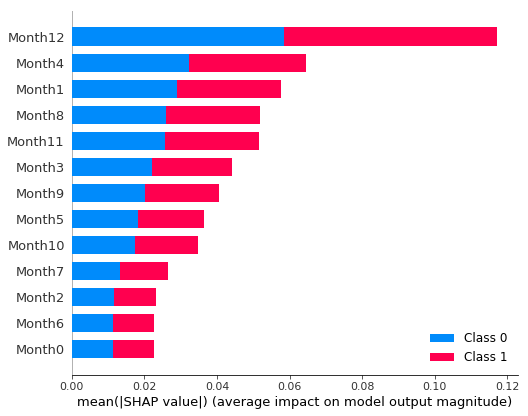

In [274]:
feature_names = ['Month'+ str(i) for i in range(13)]
shap.summary_plot(shap_values_rfb_v, feature_names=feature_names, max_display=20)

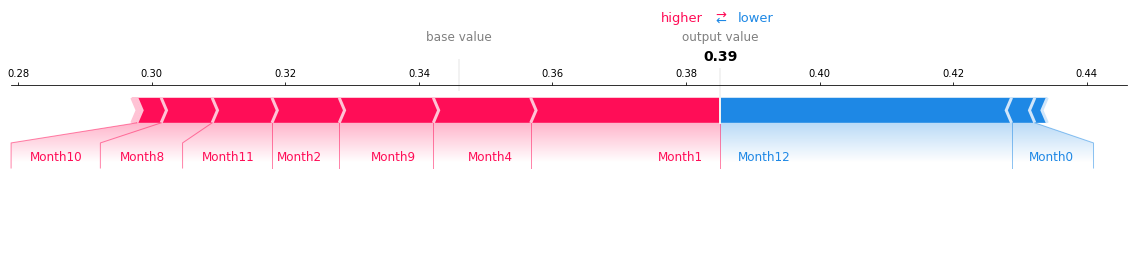

In [275]:
single_shap_values = explainer_rfb.shap_values(X_var[31])
shap.force_plot(explainer_rfb.expected_value[0], single_shap_values[0], feature_names, matplotlib=True)

In [592]:
shap.force_plot(explainer_rfb.expected_value[0], X_var_test[np.where(y_var_test[:,5]==0)[0],:], feature_names)

In [593]:
shap.force_plot(explainer_rfb.expected_value[0], X_var_test, feature_names)

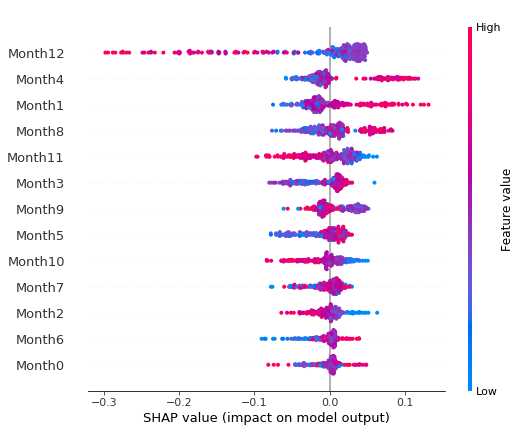

In [276]:
shap.summary_plot(shap_values_rfb_v[1], X_var, feature_names=feature_names)

## LSTM

In [ ]:
#Single LSTM binary output
def create_model2(h1=100, dropout=0.2, recurrent_dropout=0.2):
    var_input = Input(shape=(WINDOW_SIZE, 1))
    var_lstm = LSTM(h1, dropout=dropout, recurrent_dropout=recurrent_dropout)
    var_output = var_lstm(var_input)

    classifier = Dense(1, activation='sigmoid')
    model_output = classifier(var_output)

    model = Model(var_input, model_output)
    model.compile(optimizer='adam', loss='binary_crossentropy')
    
    return model

In [ ]:
model_lstm1b_v = Pipeline([
    ('sampling', RandomOverSampler()), 
    ('reshape', Reshape()),
    ('clf', KerasClassifier(create_model2, epochs=60, batch_size=16, verbose=0))
])

results_lstm1b_v = evaluate_model4(model_lstm1b_v, X_var_train, X_var_test, yb_var_train, yb_var_test, 5)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))


precision_macro 0.13
precision_micro 0.613
recall_macro 0.182
recall_micro 0.613
f1_macro 0.152
f1_micro 0.613
gms_macro 0.378
gms_micro 0.744


In [292]:
X_summary = shap.kmeans(X_var, 50)   #Karim: note the use of Kmeans here (put in the article)
explainer_lstm1b_v = shap.KernelExplainer(model_lstm1b_v.predict_proba, X_summary)
shap_values_lstm1b_v = explainer_lstm1b_v.shap_values(X_var)







  0%|          | 0/286 [00:00<?, ?it/s]





  0%|          | 1/286 [00:26<2:07:59, 26.94s/it]





  1%|          | 2/286 [00:53<2:07:05, 26.85s/it]





  1%|          | 3/286 [01:20<2:06:36, 26.84s/it]





  1%|▏         | 4/286 [01:47<2:06:04, 26.82s/it]





  2%|▏         | 5/286 [02:14<2:05:38, 26.83s/it]





  2%|▏         | 6/286 [02:40<2:05:10, 26.82s/it]





  2%|▏         | 7/286 [03:07<2:04:35, 26.79s/it]





  3%|▎         | 8/286 [03:34<2:04:11, 26.80s/it]





  3%|▎         | 9/286 [04:01<2:03:36, 26.78s/it]





  3%|▎         | 10/286 [04:27<2:03:14, 26.79s/it]





  4%|▍         | 11/286 [04:54<2:02:52, 26.81s/it]





  4%|▍         | 12/286 [05:21<2:02:31, 26.83s/it]





  5%|▍         | 13/286 [05:48<2:01:53, 26.79s/it]





  5%|▍         | 14/286 [06:15<2:01:33, 26.82s/it]





  5%|▌         | 15/286 [06:42<2:01:07, 26.82s/it]





  6%|▌         | 16/286 [07:08<2:00:39, 26.81s/it]





  6%|▌         | 17/286 [07:35<2:00:14, 26.82s/it]





  6%|▋

 76%|███████▌  | 218/286 [1:36:59<30:13, 26.67s/it]





 77%|███████▋  | 219/286 [1:37:26<29:41, 26.59s/it]





 77%|███████▋  | 220/286 [1:37:52<29:13, 26.57s/it]





 77%|███████▋  | 221/286 [1:38:19<28:46, 26.56s/it]





 78%|███████▊  | 222/286 [1:38:45<28:22, 26.60s/it]





 78%|███████▊  | 223/286 [1:39:12<27:57, 26.63s/it]





 78%|███████▊  | 224/286 [1:39:39<27:29, 26.60s/it]





 79%|███████▊  | 225/286 [1:40:05<27:03, 26.61s/it]





 79%|███████▉  | 226/286 [1:40:32<26:36, 26.61s/it]





 79%|███████▉  | 227/286 [1:40:58<26:10, 26.63s/it]





 80%|███████▉  | 228/286 [1:41:25<25:45, 26.64s/it]





 80%|████████  | 229/286 [1:41:52<25:18, 26.65s/it]





 80%|████████  | 230/286 [1:42:18<24:52, 26.66s/it]





 81%|████████  | 231/286 [1:42:45<24:25, 26.65s/it]





 81%|████████  | 232/286 [1:43:12<23:56, 26.61s/it]





 81%|████████▏ | 233/286 [1:43:38<23:27, 26.56s/it]





 82%|████████▏ | 234/286 [1:44:05<23:01, 26.56s/it]





 82%|████████▏ | 235/286 [1:44:

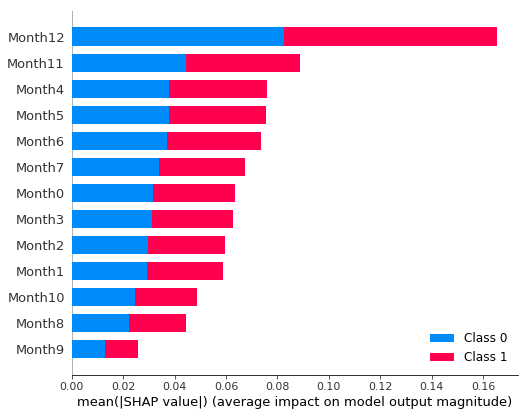

In [293]:
feature_names = ['Month'+ str(i) for i in range(13)]
shap.summary_plot(shap_values_lstm1b_v, feature_names=feature_names, max_display=20)

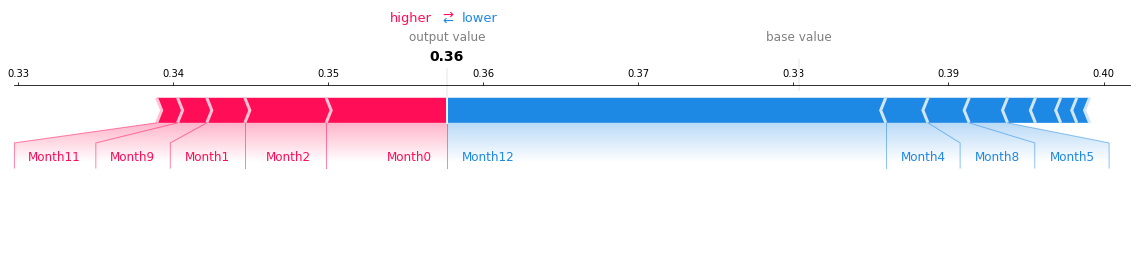

In [294]:
single_shap_values = explainer_lstm1b_v.shap_values(X_var[31])
shap.force_plot(explainer_lstm1b_v.expected_value[0], single_shap_values[0], feature_names, matplotlib=True)

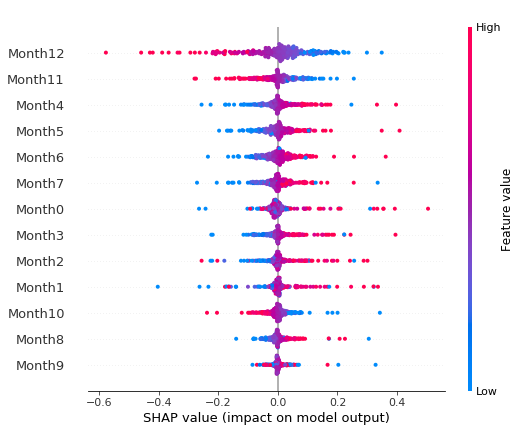

In [295]:
shap.summary_plot(shap_values_lstm1b_v[1], X_var, feature_names=feature_names)

# <font color='red'>Binary classification VAR+POS</font>

In [141]:
def define_evaluate_shap(pipeline, xtrain, xtest, ytrain, ytest, X, feature_names, runs=100, print_results=True, 
                         RunSHAP=True, plot_SHAP=False):
    #Create pipeline
    model = Pipeline(pipeline)
    
    #evaluate model

    results = evaluate_model4(model, xtrain, xtest, ytrain, ytest, runs)
    if print_results:
        for metric, value in results.items():
            print(metric,'\t', np.round(np.mean(value), 3))
    
    if RunSHAP:
        explainer, shap_values = get_shap_plot_summary(model, X, feature_names)
        if plot_SHAP:
            shap_plot_summary(shap_values, X, feature_names)

        return (model, results, explainer, shap_values)
    else:
        return (model, results)
        

feature_names_v_p = ['Var_Month'+ str(i) for i in range(0,13)] + ['POS_Month'+ str(i) for i in range(13)]

yb_train = y_train[:,5]
yb_test = y_test[:,5]

## kNN binary VAR+POS

precision_macro 	 0.449
precision_micro 	 0.534
recall_macro 	 0.447
recall_micro 	 0.534
f1_macro 	 0.448
f1_micro 	 0.534
gms_macro 	 0.447
gms_micro 	 0.534


100%|██████████| 286/286 [06:16<00:00,  1.29s/it]


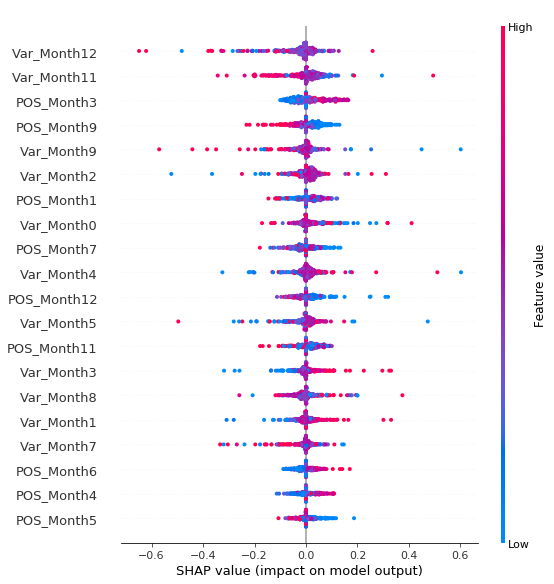

In [128]:
pipeline_knnb_v_p = [
    ('sampling', RandomOverSampler()),
    ('clf', KNeighborsClassifier(1))
]

model_knnb_v_p, results_knnb_v_p, explainer_knnb_v_p, shap_values_knnb_v_p = define_evaluate_shap(
    pipeline_knnb_v_p, X_train, X_test, yb_train, yb_test, 
    X, feature_names_v_p, runs=100, print_results=True)

## SVM binary VAR+POS

precision_macro 	 0.452
precision_micro 	 0.563
recall_macro 	 0.455
recall_micro 	 0.563
f1_macro 	 0.452
f1_micro 	 0.563
gms_macro 	 0.455
gms_micro 	 0.563





  0%|          | 0/286 [00:00<?, ?it/s]


  0%|          | 1/286 [00:01<07:17,  1.53s/it]


  1%|          | 2/286 [00:03<07:31,  1.59s/it]


  1%|          | 3/286 [00:04<07:18,  1.55s/it]


  1%|▏         | 4/286 [00:06<07:09,  1.52s/it]


  2%|▏         | 5/286 [00:07<07:12,  1.54s/it]


  2%|▏         | 6/286 [00:09<07:01,  1.51s/it]


  2%|▏         | 7/286 [00:10<06:48,  1.46s/it]


  3%|▎         | 8/286 [00:11<06:43,  1.45s/it]


  3%|▎         | 9/286 [00:13<06:39,  1.44s/it]


  3%|▎         | 10/286 [00:14<06:34,  1.43s/it]


  4%|▍         | 11/286 [00:16<06:28,  1.41s/it]


  4%|▍         | 12/286 [00:17<06:23,  1.40s/it]


  5%|▍         | 13/286 [00:18<06:20,  1.39s/it]


  5%|▍         | 14/286 [00:20<06:17,  1.39s/it]


  5%|▌         | 15/286 [00:21<06:20,  1.40s/it]


  6%|▌         | 16/286 [00:23<06:24,  1.42s/it]


  6%|▌         | 17/286 [00:24<06:25,  1.43s/it]


  6%|▋         | 18/286 [00:26<06:31,  1.46s/it]


  7%|▋         | 19/286 [00:27<06:23,  1.44s/i

 94%|█████████▍| 270/286 [06:20<00:22,  1.39s/it]


 95%|█████████▍| 271/286 [06:21<00:20,  1.38s/it]


 95%|█████████▌| 272/286 [06:22<00:19,  1.39s/it]


 95%|█████████▌| 273/286 [06:24<00:17,  1.38s/it]


 96%|█████████▌| 274/286 [06:25<00:16,  1.40s/it]


 96%|█████████▌| 275/286 [06:27<00:15,  1.41s/it]


 97%|█████████▋| 276/286 [06:28<00:13,  1.40s/it]


 97%|█████████▋| 277/286 [06:29<00:12,  1.39s/it]


 97%|█████████▋| 278/286 [06:31<00:11,  1.40s/it]


 98%|█████████▊| 279/286 [06:32<00:09,  1.39s/it]


 98%|█████████▊| 280/286 [06:34<00:08,  1.38s/it]


 98%|█████████▊| 281/286 [06:35<00:06,  1.38s/it]


 99%|█████████▊| 282/286 [06:36<00:05,  1.40s/it]


 99%|█████████▉| 283/286 [06:38<00:04,  1.41s/it]


 99%|█████████▉| 284/286 [06:39<00:02,  1.41s/it]


100%|█████████▉| 285/286 [06:41<00:01,  1.40s/it]


100%|██████████| 286/286 [06:42<00:00,  1.39s/it]

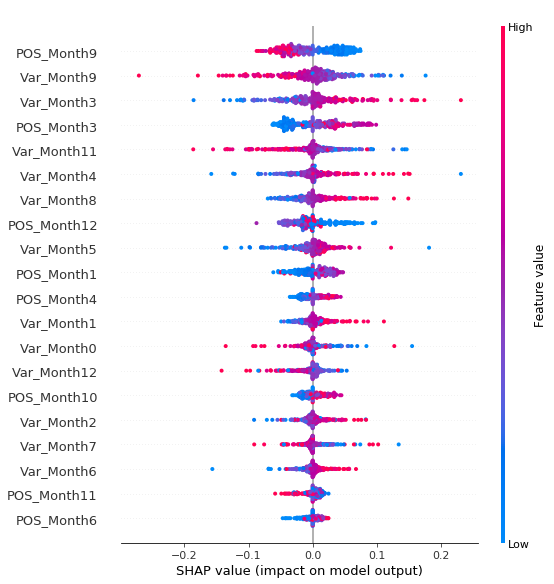

In [136]:
pipeline_svmb_v_p = [
    ('sampling', RandomOverSampler()),
    ('clf', SVC(C=10, gamma=0.1, probability=True))
]

model_svmb_v_p, results_svmb_v_p, explainer_svmb_v_p, shap_values_svmb_v_p = define_evaluate_shap(
    pipeline_svmb_v_p, X_train, X_test, yb_train, yb_test, 
    X, feature_names_v_p, runs=100, print_results=True)

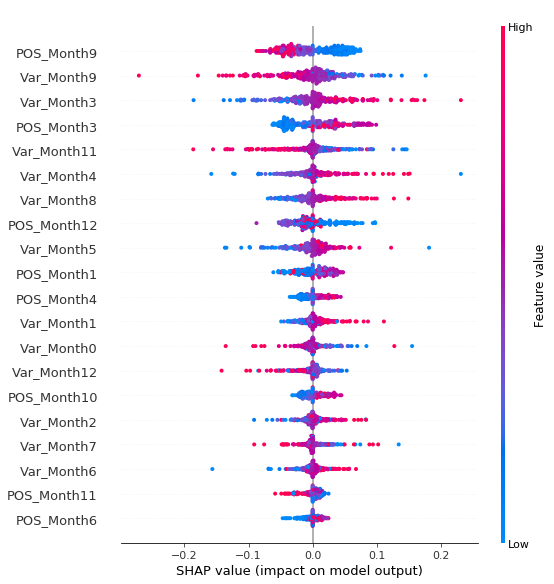

In [143]:
shap_plot_summary(shap_values_svmb_v_p, X, feature_names_v_p)

## Random Forest binary VAR+POS

In [144]:
pipeline_rfb_v_p = [
    ('sampling', RandomOverSampler()),
    ('clf', RandomForestClassifier(200, max_depth=5))
]

model_rfb_v_p, results_rfb_v_p, explainer_rfb_v_p, shap_values_rfb_v_p = define_evaluate_shap(
    pipeline_rfb_v_p, X_train, X_test, yb_train, yb_test, 
    X, feature_names_v_p, runs=100, print_results=True)

precision_macro 	 0.518
precision_micro 	 0.613
recall_macro 	 0.518
recall_micro 	 0.613
f1_macro 	 0.517
f1_micro 	 0.613
gms_macro 	 0.518
gms_micro 	 0.613





  0%|          | 0/286 [00:00<?, ?it/s]


  0%|          | 1/286 [00:01<08:43,  1.84s/it]


  1%|          | 2/286 [00:03<08:46,  1.85s/it]


  1%|          | 3/286 [00:05<08:47,  1.86s/it]


  1%|▏         | 4/286 [00:07<08:55,  1.90s/it]


  2%|▏         | 5/286 [00:09<08:50,  1.89s/it]


  2%|▏         | 6/286 [00:11<08:45,  1.88s/it]


  2%|▏         | 7/286 [00:13<08:40,  1.87s/it]


  3%|▎         | 8/286 [00:15<08:39,  1.87s/it]


  3%|▎         | 9/286 [00:16<08:34,  1.86s/it]


  3%|▎         | 10/286 [00:18<08:30,  1.85s/it]


  4%|▍         | 11/286 [00:20<08:29,  1.85s/it]


  4%|▍         | 12/286 [00:22<08:41,  1.90s/it]


  5%|▍         | 13/286 [00:24<08:36,  1.89s/it]


  5%|▍         | 14/286 [00:26<08:29,  1.87s/it]


  5%|▌         | 15/286 [00:28<08:25,  1.86s/it]


  6%|▌         | 16/286 [00:29<08:21,  1.86s/it]


  6%|▌         | 17/286 [00:31<08:25,  1.88s/it]


  6%|▋         | 18/286 [00:33<08:20,  1.87s/it]


  7%|▋         | 19/286 [00:35<08:17,  1.86s/i

 94%|█████████▍| 270/286 [08:27<00:29,  1.86s/it]


 95%|█████████▍| 271/286 [08:29<00:27,  1.86s/it]


 95%|█████████▌| 272/286 [08:31<00:26,  1.86s/it]


 95%|█████████▌| 273/286 [08:33<00:24,  1.86s/it]


 96%|█████████▌| 274/286 [08:35<00:22,  1.88s/it]


 96%|█████████▌| 275/286 [08:37<00:20,  1.89s/it]


 97%|█████████▋| 276/286 [08:39<00:18,  1.89s/it]


 97%|█████████▋| 277/286 [08:41<00:16,  1.88s/it]


 97%|█████████▋| 278/286 [08:43<00:15,  1.88s/it]


 98%|█████████▊| 279/286 [08:44<00:13,  1.88s/it]


 98%|█████████▊| 280/286 [08:46<00:11,  1.87s/it]


 98%|█████████▊| 281/286 [08:48<00:09,  1.86s/it]


 99%|█████████▊| 282/286 [08:50<00:07,  1.86s/it]


 99%|█████████▉| 283/286 [08:52<00:05,  1.87s/it]


 99%|█████████▉| 284/286 [08:54<00:03,  1.88s/it]


100%|█████████▉| 285/286 [08:56<00:01,  1.90s/it]


100%|██████████| 286/286 [08:58<00:00,  1.91s/it]

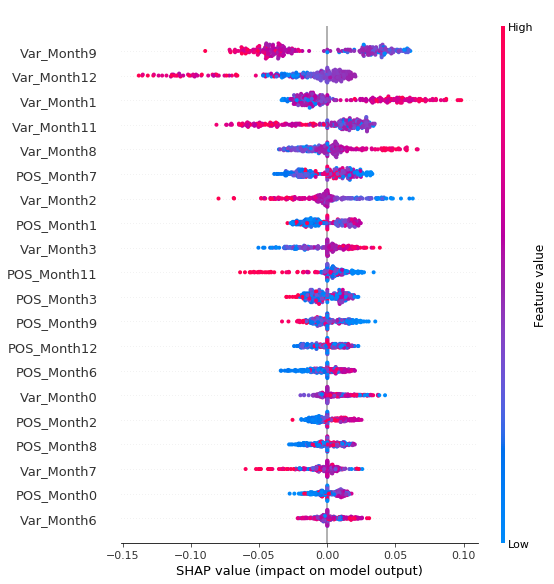

In [145]:
shap_plot_summary(shap_values_rfb_v_p, X, feature_names_v_p)

## XGBoost binary VAR+POS

In [146]:
pipeline_GBb_v_p = [
    ('sampling', RandomOverSampler()),
    ('clf', GradientBoostingClassifier(learning_rate=0.025, max_depth=8, 
                                       min_samples_leaf=0.1, min_samples_split=0.136))
]

model_GBb_v_p, results_GBb_v_p, explainer_GBb_v_p, shap_values_GBb_v_p = define_evaluate_shap(
    pipeline_GBb_v_p, X_train, X_test, yb_train, yb_test, 
    X, feature_names_v_p, runs=100, print_results=True)

precision_macro 	 0.575
precision_micro 	 0.641
recall_macro 	 0.576
recall_micro 	 0.641
f1_macro 	 0.574
f1_micro 	 0.641
gms_macro 	 0.576
gms_micro 	 0.641





  0%|          | 0/286 [00:00<?, ?it/s]


  0%|          | 1/286 [00:00<03:15,  1.46it/s]


  1%|          | 2/286 [00:01<03:15,  1.45it/s]


  1%|          | 3/286 [00:02<03:15,  1.44it/s]


  1%|▏         | 4/286 [00:02<03:18,  1.42it/s]


  2%|▏         | 5/286 [00:03<03:19,  1.41it/s]


  2%|▏         | 6/286 [00:04<03:17,  1.42it/s]


  2%|▏         | 7/286 [00:04<03:14,  1.43it/s]


  3%|▎         | 8/286 [00:05<03:21,  1.38it/s]


  3%|▎         | 9/286 [00:06<03:21,  1.38it/s]


  3%|▎         | 10/286 [00:07<03:17,  1.40it/s]


  4%|▍         | 11/286 [00:07<03:13,  1.42it/s]


  4%|▍         | 12/286 [00:08<03:13,  1.42it/s]


  5%|▍         | 13/286 [00:09<03:11,  1.43it/s]


  5%|▍         | 14/286 [00:09<03:10,  1.43it/s]


  5%|▌         | 15/286 [00:10<03:10,  1.42it/s]


  6%|▌         | 16/286 [00:11<03:10,  1.42it/s]


  6%|▌         | 17/286 [00:12<03:09,  1.42it/s]


  6%|▋         | 18/286 [00:12<03:08,  1.42it/s]


  7%|▋         | 19/286 [00:13<03:06,  1.43it/

 94%|█████████▍| 270/286 [03:15<00:11,  1.37it/s]


 95%|█████████▍| 271/286 [03:16<00:10,  1.39it/s]


 95%|█████████▌| 272/286 [03:17<00:10,  1.39it/s]


 95%|█████████▌| 273/286 [03:17<00:09,  1.40it/s]


 96%|█████████▌| 274/286 [03:18<00:08,  1.42it/s]


 96%|█████████▌| 275/286 [03:19<00:07,  1.42it/s]


 97%|█████████▋| 276/286 [03:20<00:07,  1.38it/s]


 97%|█████████▋| 277/286 [03:20<00:06,  1.39it/s]


 97%|█████████▋| 278/286 [03:21<00:05,  1.40it/s]


 98%|█████████▊| 279/286 [03:22<00:05,  1.40it/s]


 98%|█████████▊| 280/286 [03:22<00:04,  1.41it/s]


 98%|█████████▊| 281/286 [03:23<00:03,  1.39it/s]


 99%|█████████▊| 282/286 [03:24<00:02,  1.40it/s]


 99%|█████████▉| 283/286 [03:25<00:02,  1.38it/s]


 99%|█████████▉| 284/286 [03:25<00:01,  1.41it/s]


100%|█████████▉| 285/286 [03:26<00:00,  1.41it/s]


100%|██████████| 286/286 [03:27<00:00,  1.42it/s]

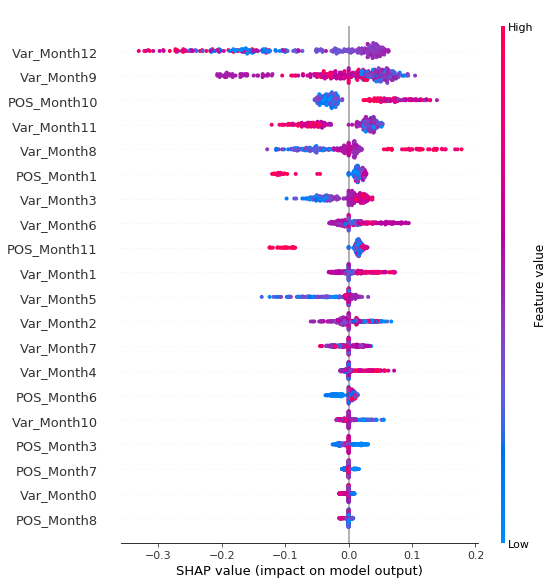

In [147]:
shap_plot_summary(shap_values_GBb_v_p, X, feature_names_v_p)

## Single LSTM VAR+POS

In [113]:
#Single LSTM VAR+POS binary output
def create_model4(h1=100, dropout=0.2, recurrent_dropout=0.2):
    var_input = Input(shape=(WINDOW_SIZE*2,1))
    var_lstm = LSTM(h1, dropout=dropout, recurrent_dropout=recurrent_dropout)
    var_output = var_lstm(var_input)

    classifier = Dense(1, activation='sigmoid')
    model_output = classifier(var_output)

    model = Model(var_input, model_output)
    model.compile(optimizer='adam', loss='binary_crossentropy')
    
    return model

In [151]:
pipeline_lstm1b_v_p = [
    ('sampling', RandomOverSampler()), 
    ('reshape', Reshape()),
    ('clf', KerasClassifier(create_model4, epochs=20, batch_size=16, verbose=0))
]

model_lstm1b_v_p, results_lstm1b_v_p = define_evaluate_shap(
    pipeline_lstm1b_v_p, X_train, X_test, yb_train, yb_test, 
    X, feature_names_v_p, runs=10, print_results=True, RunSHAP=False)

precision_macro 	 0.489
precision_micro 	 0.509
recall_macro 	 0.484
recall_micro 	 0.509
f1_macro 	 0.472
f1_micro 	 0.509
gms_macro 	 0.484
gms_micro 	 0.509


In [154]:
model_lstm1b_v_p, results_lstm1b_v_p, explainer_lstm1b_v_p, shap_values_lstm1b_v_p = define_evaluate_shap(
    pipeline_lstm1b_v_p, X_train, X_test, yb_train, yb_test, 
    X, feature_names_v_p, runs=1, print_results=True, RunSHAP=True)
#TODO: Rerun again for SHAP, don't consider metrics (run=1)

precision_macro 	 0.452
precision_micro 	 0.431
recall_macro 	 0.443
recall_micro 	 0.431
f1_macro 	 0.417
f1_micro 	 0.431
gms_macro 	 0.443
gms_micro 	 0.431






  0%|          | 0/286 [00:00<?, ?it/s]



  0%|          | 1/286 [00:39<3:08:54, 39.77s/it]



  1%|          | 2/286 [01:19<3:08:12, 39.76s/it]



  2%|▏         | 6/286 [03:57<3:04:48, 39.60s/it]



  2%|▏         | 7/286 [04:37<3:04:33, 39.69s/it]



  3%|▎         | 8/286 [05:17<3:04:06, 39.74s/it]



  3%|▎         | 9/286 [05:56<3:03:31, 39.75s/it]



  3%|▎         | 10/286 [06:36<3:02:50, 39.75s/it]



  4%|▍         | 11/286 [07:16<3:02:22, 39.79s/it]



  4%|▍         | 12/286 [07:56<3:01:50, 39.82s/it]



  5%|▍         | 13/286 [08:36<3:01:02, 39.79s/it]



  5%|▍         | 14/286 [09:15<3:00:31, 39.82s/it]



  5%|▌         | 15/286 [09:55<2:59:53, 39.83s/it]



  6%|▌         | 16/286 [10:35<2:59:16, 39.84s/it]



  6%|▌         | 17/286 [11:15<2:58:39, 39.85s/it]



  6%|▋         | 18/286 [11:55<2:57:45, 39.80s/it]



  7%|▋         | 19/286 [12:34<2:57:01, 39.78s/it]



  7%|▋         | 20/286 [13:14<2:56:18, 39.77s/it]



  7%|▋         | 21/286 [13:53<2:54:14, 3

 44%|████▍     | 126/286 [1:19:41<1:39:08, 37.18s/it]



 44%|████▍     | 127/286 [1:20:18<1:38:23, 37.13s/it]



 45%|████▍     | 128/286 [1:20:55<1:37:53, 37.17s/it]



 45%|████▌     | 129/286 [1:21:32<1:37:13, 37.15s/it]



 45%|████▌     | 130/286 [1:22:09<1:36:31, 37.13s/it]



 46%|████▌     | 131/286 [1:22:46<1:35:41, 37.04s/it]



 46%|████▌     | 132/286 [1:23:23<1:35:05, 37.05s/it]



 47%|████▋     | 133/286 [1:24:00<1:34:07, 36.91s/it]



 47%|████▋     | 134/286 [1:24:36<1:33:22, 36.86s/it]



 47%|████▋     | 135/286 [1:25:35<1:49:31, 43.52s/it]



 48%|████▊     | 136/286 [1:26:12<1:43:54, 41.56s/it]



 48%|████▊     | 137/286 [1:26:59<1:47:05, 43.13s/it]



 48%|████▊     | 138/286 [1:27:37<1:42:20, 41.49s/it]



 49%|████▊     | 139/286 [1:28:17<1:40:26, 41.00s/it]



 49%|████▉     | 140/286 [1:28:57<1:38:59, 40.68s/it]



 49%|████▉     | 141/286 [1:29:36<1:37:39, 40.41s/it]



 50%|████▉     | 142/286 [1:30:16<1:36:35, 40.25s/it]



 50%|█████     | 143/286 [1:30:

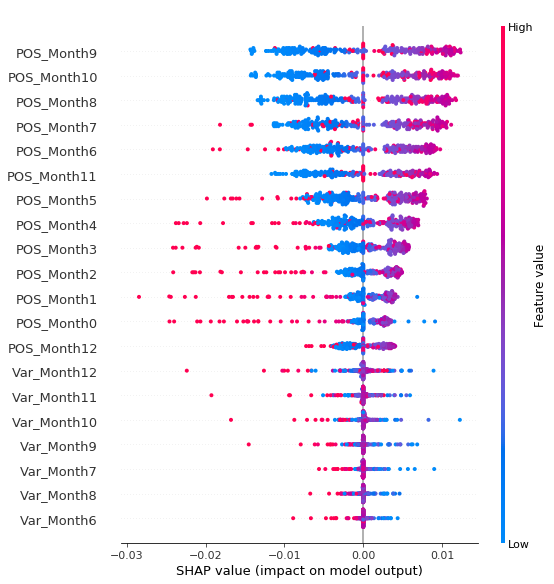

In [155]:
shap_plot_summary(shap_values_lstm1b_v_p, X, feature_names_v_p)

## bi-LSTM binary POS+VAR

In [131]:
#bi-LSTM (Variance and POS) binary
def create_model5(h1=100, h2=60, d1=0.2, rd1=0.2, d2=0.2, rd2=0.2):
    var_input = Input(shape=(WINDOW_SIZE, 1), dtype='float32')
    var_lstm = LSTM(h1, dropout=d1, recurrent_dropout=rd1)
    var_output = var_lstm(var_input)

    pos_input = Input(shape=(WINDOW_SIZE, 1), dtype='float32')
    pos_lstm = LSTM(h2, dropout=d2, recurrent_dropout=rd2)
    pos_output = pos_lstm(pos_input)

    merged = concatenate([var_output, pos_output])
    classifier = Dense(1, activation='sigmoid')
    model_output = classifier(merged)

    model = Model([var_input, pos_input], model_output)
    model.compile(optimizer='adam', loss='binary_crossentropy')
    
    return model

In [158]:
pipeline_lstm2b_v_p = [
    ('sampling', RandomOverSampler()), 
    ('reshape', SplitAndReshape()),
    ('clf', KerasClassifier(create_model5, epochs=20, batch_size=16, verbose=0))
]

model_lstm2b_v_p, results_lstm2b_v_p = define_evaluate_shap(
    pipeline_lstm2b_v_p, X_train, X_test, yb_train, yb_test, 
    X, feature_names_v_p, runs=10, print_results=True, RunSHAP=False)

KeyboardInterrupt: 

In [159]:
model_lstm2b_v_p, results_lstm2b_v_p, explainer_lstm2b_v_p, shap_values_lstm2b_v_p = define_evaluate_shap(
    pipeline_lstm2b_v_p, X_train, X_test, yb_train, yb_test, 
    X, feature_names_v_p, runs=1, print_results=True, RunSHAP=True)

precision_macro 	 0.458
precision_micro 	 0.466
recall_macro 	 0.45
recall_micro 	 0.466
f1_macro 	 0.437
f1_micro 	 0.466
gms_macro 	 0.45
gms_micro 	 0.466






  0%|          | 0/286 [00:00<?, ?it/s]



  0%|          | 1/286 [00:27<2:10:25, 27.46s/it]



  1%|          | 2/286 [00:54<2:09:56, 27.45s/it]



  1%|          | 3/286 [01:22<2:09:32, 27.46s/it]



  1%|▏         | 4/286 [01:49<2:09:04, 27.46s/it]



  2%|▏         | 5/286 [02:17<2:08:49, 27.51s/it]



  2%|▏         | 6/286 [02:44<2:08:18, 27.50s/it]



  2%|▏         | 7/286 [03:12<2:08:00, 27.53s/it]



  3%|▎         | 8/286 [03:40<2:07:38, 27.55s/it]



  3%|▎         | 9/286 [04:07<2:07:19, 27.58s/it]



  3%|▎         | 10/286 [04:35<2:06:48, 27.57s/it]



  4%|▍         | 11/286 [05:02<2:06:11, 27.53s/it]



  4%|▍         | 12/286 [05:30<2:05:38, 27.51s/it]



  5%|▍         | 13/286 [05:57<2:05:05, 27.49s/it]



  5%|▍         | 14/286 [06:25<2:04:42, 27.51s/it]



  5%|▌         | 15/286 [06:52<2:04:17, 27.52s/it]



  6%|▌         | 16/286 [07:20<2:03:49, 27.52s/it]



  6%|▌         | 17/286 [07:47<2:03:26, 27.53s/it]



  6%|▋         | 18/286 [08:15<2:03:10, 27.5

 86%|████████▋ | 247/286 [1:53:16<17:52, 27.50s/it]



 87%|████████▋ | 248/286 [1:53:43<17:23, 27.47s/it]



 87%|████████▋ | 249/286 [1:54:11<16:56, 27.47s/it]



 87%|████████▋ | 250/286 [1:54:38<16:30, 27.52s/it]



 88%|████████▊ | 251/286 [1:55:06<16:03, 27.53s/it]



 88%|████████▊ | 252/286 [1:55:33<15:35, 27.52s/it]



 88%|████████▊ | 253/286 [1:56:01<15:08, 27.52s/it]



 89%|████████▉ | 254/286 [1:56:28<14:39, 27.49s/it]



 89%|████████▉ | 255/286 [1:56:56<14:13, 27.53s/it]



 90%|████████▉ | 256/286 [1:57:23<13:45, 27.52s/it]



 90%|████████▉ | 257/286 [1:57:51<13:17, 27.49s/it]



 90%|█████████ | 258/286 [1:58:18<12:49, 27.49s/it]



 91%|█████████ | 259/286 [1:58:46<12:22, 27.48s/it]



 91%|█████████ | 260/286 [1:59:13<11:53, 27.44s/it]



 91%|█████████▏| 261/286 [1:59:40<11:26, 27.46s/it]



 92%|█████████▏| 262/286 [2:00:08<10:58, 27.45s/it]



 92%|█████████▏| 263/286 [2:00:35<10:31, 27.44s/it]



 92%|█████████▏| 264/286 [2:01:03<10:03, 27.43s/it]



 93%|█████

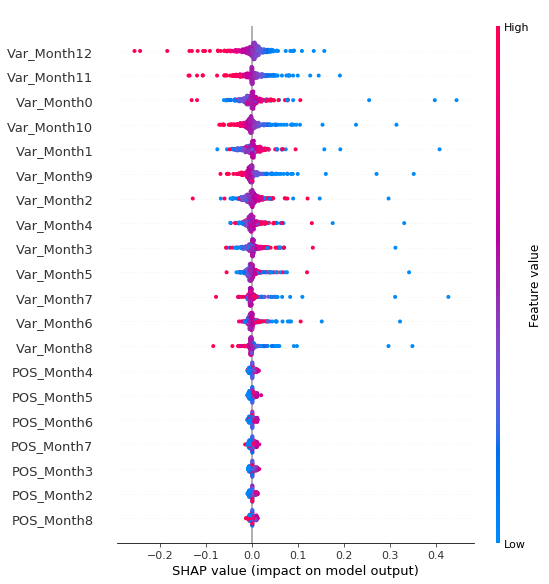

In [160]:
shap_plot_summary(shap_values_lstm2b_v_p, X, feature_names_v_p)

In [296]:
def calc_metrics(results):
    return({metric: np.round(np.mean(value), 3) for metric, value in results.items() })
#     for metric, value in results.items():
#         print(metric, '\t', np.round(np.mean(value), 3))

models = ['GB', 'knn', 'rf', 'svm', 'lstm1', 'lstm2']   #, 'lstm2'
models_b_v = [m+"b_v" for m in models]
models_b_v_p = [m+"b_v_p" for m in models]
suffixes = ['b_v_p', 'b_v']
all_results = {}

for m in models:
    all_results[m] = {}
    for s in suffixes:
        if (m=='lstm2') & (s=='b_v'): continue   #does not exist
        all_results[m][s] = {}
        all_results[m][s]['shap_value'] = eval('shap_values_'+m+s)
        all_results[m][s]['results'] = calc_metrics(eval('results_'+m+s))

In [298]:
from helper_save_load import save_to_pickle

save_to_pickle("all_results.pkl", all_results)

<BarContainer object of 26 artists>

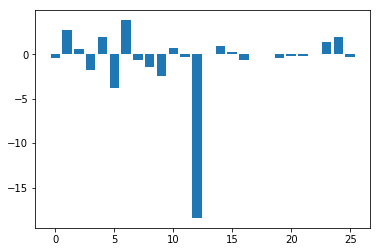

In [313]:
plt.bar(x=range(26),height=np.sum(np.array(all_results['GB']['b_v_p']['shap_value'])[1], axis=0))

<BarContainer object of 26 artists>

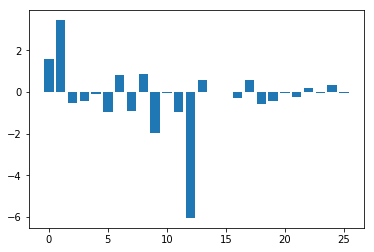

In [316]:
plt.bar(x=range(26),height=np.sum(np.array(all_results['rf']['b_v_p']['shap_value'])[1], axis=0))

<BarContainer object of 13 artists>

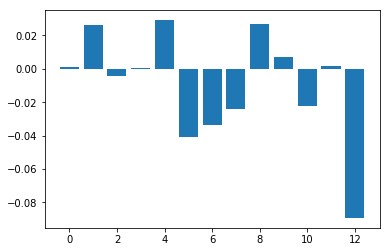

In [334]:
sum1 = np.zeros(13)
for m in models:
    if m=='lstm2': continue
    shap_v = np.mean(np.array(all_results[m]['b_v']['shap_value'])[1], axis=0)
    sum1 += shap_v
plt.bar(x=range(13),height=sum1)


In [332]:
all_results['svm']['b_v']['results']['f1_micro']

0.714

<BarContainer object of 13 artists>

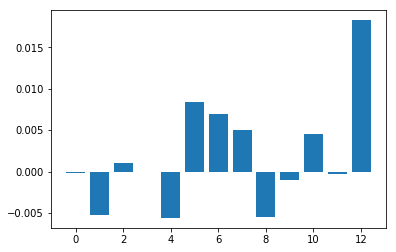

In [354]:
sum1 = np.zeros(13)
sum_f1 = 0
for m in models:
    if m=='lstm2': continue
    shap_v = np.mean(np.array(all_results[m]['b_v']['shap_value'])[0], axis=0)
    f1 = all_results[m]['b_v']['results']['f1_micro']
    sum1 += shap_v * f1
    sum_f1 += f1
plt.bar(x=range(13),height=sum1/sum_f1)

0


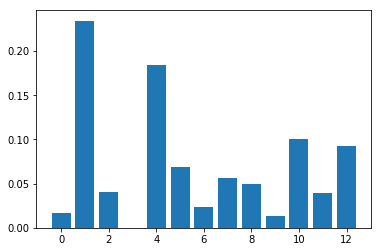

In [358]:
index = 6
plt.bar(x=range(13),height=np.array(all_results['knn']['b_v']['shap_value'])[0][index])
print(y[index][5])

# Training with SHAP values

In [502]:
X_shap = np.array(all_results['svm']['b_v']['shap_value'])[0]
yb = (y[:,5] == 0)*1

In [503]:
X_shap.shape

(286, 13)

In [504]:
X_shap_train, X_shap_test, y_shap_train, y_shap_test = train_test_split(X_shap, yb, test_size=0.2, random_state=4)

In [505]:
y_shap_test

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0])

In [506]:
(y_test[:,5]==0)*1

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0])

In [507]:
model_knn_shap = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', KNeighborsClassifier(1))
])



results = evaluate_model4(model_knn_shap, X_shap_train, X_shap_test, y_shap_train, y_shap_test, 100)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))
print('training with original dataset',all_results['knn']['b_v']['results']['f1_micro'])

precision_macro 0.902
precision_micro 0.828
recall_macro 0.706
recall_micro 0.828
f1_macro 0.737
f1_micro 0.828
gms_macro 0.706
gms_micro 0.828
training with original dataset 0.724


In [508]:
model_GBb_shap = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', GradientBoostingClassifier(learning_rate=0.025, max_depth=8, 
                                       min_samples_leaf=0.1, min_samples_split=0.136))
])

results = evaluate_model4(model_GBb_shap, X_shap_train, X_shap_test, y_shap_train, y_shap_test, 100)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))
print('training with original dataset',all_results['GB']['b_v']['results']['f1_micro'])

precision_macro 0.741
precision_micro 0.783
recall_macro 0.75
recall_micro 0.783
f1_macro 0.744
f1_micro 0.783
gms_macro 0.75
gms_micro 0.783
training with original dataset 0.67


In [509]:
model_svmb_shap = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', SVC(C=10, gamma=1))
])
results = evaluate_model4(model_svmb_shap, X_shap_train, X_shap_test, y_shap_train, y_shap_test, 100)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))
print('training with original dataset',all_results['svm']['b_v']['results']['f1_micro'])

precision_macro 0.814
precision_micro 0.831
recall_macro 0.761
recall_micro 0.831
f1_macro 0.779
f1_micro 0.831
gms_macro 0.761
gms_micro 0.831
training with original dataset 0.714


In [510]:
model_rfb_shap = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', RandomForestClassifier(200, max_depth=5))
])
results = evaluate_model4(model_rfb_shap, X_shap_train, X_shap_test, y_shap_train, y_shap_test, 100)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))
print('training with original dataset',all_results['rf']['b_v']['results']['f1_micro'])

precision_macro 0.826
precision_micro 0.837
recall_macro 0.765
recall_micro 0.837
f1_macro 0.785
f1_micro 0.837
gms_macro 0.765
gms_micro 0.837
training with original dataset 0.696


In [511]:
sum(model_rfb_shap.predict(X_shap_test) == y_shap_test) / len(y_shap_test)

0.8620689655172413

In [512]:
model_rfb_shap.predict(X_shap_test)

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0])

In [513]:
y_shap_test

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0])

In [514]:
model_lstm1b_shap = Pipeline([
    ('sampling', RandomOverSampler()), 
    ('reshape', Reshape()),
    ('clf', KerasClassifier(create_model2, epochs=60, batch_size=16, verbose=1))
])

results = evaluate_model4(model_lstm1b_shap, X_shap_train, X_shap_test, y_shap_train, y_shap_test, 1)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))
print('training with original dataset',all_results['lstm1']['b_v']['results']['f1_micro'])

Epoch 1/60
356/356 [==============================] - 26s 73ms/step - loss: 0.6915
Epoch 2/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6334
Epoch 3/60
356/356 [==============================] - 0s 1ms/step - loss: 0.5337
Epoch 4/60
356/356 [==============================] - 0s 1ms/step - loss: 0.5366
Epoch 5/60
356/356 [==============================] - 0s 1ms/step - loss: 0.5661
Epoch 6/60
356/356 [==============================] - 0s 1ms/step - loss: 0.5578
Epoch 7/60
356/356 [==============================] - 0s 1ms/step - loss: 0.5347
Epoch 8/60
356/356 [==============================] - 0s 1ms/step - loss: 0.5309
Epoch 9/60
356/356 [==============================] - 0s 1ms/step - loss: 0.5429
Epoch 10/60
356/356 [==============================] - 0s 1ms/step - loss: 0.5252
Epoch 11/60
356/356 [==============================] - 0s 1ms/step - loss: 0.5217
Epoch 12/60
356/356 [==============================] - 0s 1ms/step - loss: 0.5297
Epoch 13/60
356/356 [==

In [515]:
sum(model_lstm1b_shap.predict(X_shap_test).reshape(1,-1)[0] == y_shap_test) / len(y_shap_test)

58/58 [==============================] - 0s 507us/step


0.8448275862068966

In [516]:
model_lstm1b_shap.predict(X_shap_test).reshape(1,-1)[0]

58/58 [==============================] - 0s 372us/step


array([0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0])

In [517]:
y_shap_test

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0])

In [519]:
#Hits
(model_lstm1b_shap.predict(X_shap_test).reshape(1,-1)[0] == y_shap_test)*1

58/58 [==============================] - 0s 484us/step


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1])

## Training with SHAP var+pos

In [486]:
X_shap_v_p = np.array(all_results['rf']['b_v_p']['shap_value'])[0]
yb = (y[:,5] == 0)*1

In [487]:
X_shap_v_p.shape, yb.shape

((286, 26), (286,))

In [488]:
X_shap_v_p_train, X_v_p_shap_test, y_v_p_shap_train, y_v_p_shap_test = train_test_split(X_shap_v_p, 
                                                                                        yb, test_size=0.2, random_state=4)

In [489]:
model_GBb_shap_v_p = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', GradientBoostingClassifier(learning_rate=0.025, max_depth=8, 
                                       min_samples_leaf=0.1, min_samples_split=0.136))
])

results = evaluate_model4(model_GBb_shap_v_p, X_shap_v_p_train, X_v_p_shap_test, y_v_p_shap_train, y_v_p_shap_test, 100)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))
print('training with original dataset',all_results['GB']['b_v_p']['results']['f1_micro'])

precision_macro 0.484
precision_micro 0.682
recall_macro 0.497
recall_micro 0.682
f1_macro 0.446
f1_micro 0.682
gms_macro 0.497
gms_micro 0.682
training with original dataset 0.641


In [490]:
sum(model_GBb_shap_v_p.predict(X_v_p_shap_test) == y_v_p_shap_test) / len(y_v_p_shap_test)

0.6896551724137931

In [491]:
model_GBb_shap_v_p.predict(X_v_p_shap_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [492]:
y_v_p_shap_test

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0])

In [493]:
model_svmb_shap_v_p = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', SVC(C=10, gamma=1))
])

results = evaluate_model4(model_svmb_shap_v_p, X_shap_v_p_train, X_v_p_shap_test, y_v_p_shap_train, y_v_p_shap_test, 100)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))
print('training with original dataset',all_results['svm']['b_v_p']['results']['f1_micro'])

precision_macro 0.492
precision_micro 0.668
recall_macro 0.497
recall_micro 0.668
f1_macro 0.461
f1_micro 0.668
gms_macro 0.497
gms_micro 0.668
training with original dataset 0.563


In [494]:
model_lstm2b_shap_v_p =  Pipeline([
    ('sampling', RandomOverSampler()), 
    ('reshape', SplitAndReshape()),
    ('clf', KerasClassifier(create_model5, epochs=60, batch_size=16, verbose=1))
])

results = evaluate_model4(model_lstm2b_shap_v_p, X_shap_v_p_train, X_v_p_shap_test, 
                          y_v_p_shap_train, y_v_p_shap_test, 1)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))
print('training with original dataset',all_results['lstm2']['b_v_p']['results']['f1_micro'])

Epoch 1/60
356/356 [==============================] - 25s 72ms/step - loss: 0.6910
Epoch 2/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6547
Epoch 3/60
356/356 [==============================] - 0s 1ms/step - loss: 0.5164
Epoch 4/60
356/356 [==============================] - 0s 1ms/step - loss: 0.4625
Epoch 5/60
356/356 [==============================] - 0s 1ms/step - loss: 0.4466
Epoch 6/60
356/356 [==============================] - 0s 1ms/step - loss: 0.4207
Epoch 7/60
356/356 [==============================] - 0s 1ms/step - loss: 0.3981
Epoch 8/60
356/356 [==============================] - 0s 1ms/step - loss: 0.4110
Epoch 9/60
356/356 [==============================] - 0s 1ms/step - loss: 0.3620
Epoch 10/60
356/356 [==============================] - 0s 1ms/step - loss: 0.3824
Epoch 11/60
356/356 [==============================] - 0s 1ms/step - loss: 0.3815
Epoch 12/60
356/356 [==============================] - 0s 1ms/step - loss: 0.3470
Epoch 13/60
356/356 [==

In [495]:
sum(model_lstm2b_shap_v_p.predict(X_v_p_shap_test).reshape(1,-1)[0] == y_shap_test) / len(y_shap_test)

58/58 [==============================] - 0s 559us/step


0.6724137931034483

In [496]:
model_lstm2b_shap_v_p.predict(X_v_p_shap_test).reshape(1,-1)[0]

58/58 [==============================] - 0s 433us/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [497]:
y_shap_test

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0])

GB
knn
rf
svm
lstm1
lstm2


<BarContainer object of 26 artists>

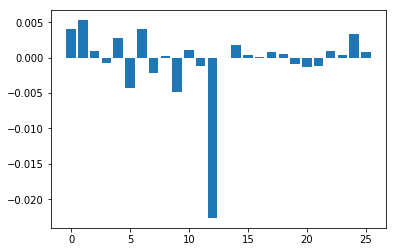

In [485]:
sum1 = np.zeros(26)
sum_f1 = 0
for m in models:
    print(m)
#     if m=='lstm2': break
    shap_v = np.mean(np.array(all_results[m]['b_v_p']['shap_value'])[1], axis=0)
    f1 = all_results[m]['b_v_p']['results']['f1_micro']
    sum1 += shap_v * f1
    sum_f1 += f1
plt.bar(x=range(26),height=sum1/sum_f1)

# Training with SHAP redoing the experiment from scratch

## Calculate SHAP values for training and test sets separately

In [520]:
model_knnb_v1 = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', KNeighborsClassifier(1))
])

In [521]:
results_knnb_v1 = evaluate_model4(model_knnb_v1, X_var_train, X_var_test, yb_var_train, yb_var_test, 100)
for metric, value in results_knnb_v.items():
    print(metric,'\t', np.round(np.mean(value), 3))

precision_macro 	 0.701
precision_micro 	 0.724
recall_macro 	 0.619
recall_micro 	 0.724
f1_macro 	 0.623
f1_micro 	 0.724
gms_macro 	 0.619
gms_micro 	 0.724


In [544]:
X_summary = shap.kmeans(X_var_train,10)
explainer = shap.KernelExplainer(model_knnb_v1.predict_proba, X_summary)
shap_values_knnb_v1_train = explainer.shap_values(X_var_train)







  0%|          | 0/228 [00:00<?, ?it/s]





  0%|          | 1/228 [00:00<01:08,  3.30it/s]





  1%|          | 2/228 [00:00<01:09,  3.27it/s]





  1%|▏         | 3/228 [00:00<01:07,  3.35it/s]





  2%|▏         | 4/228 [00:01<01:07,  3.30it/s]





  2%|▏         | 5/228 [00:01<01:07,  3.28it/s]





  3%|▎         | 6/228 [00:01<01:07,  3.29it/s]





  3%|▎         | 7/228 [00:02<01:07,  3.28it/s]





  4%|▎         | 8/228 [00:02<01:07,  3.26it/s]





  4%|▍         | 9/228 [00:02<01:07,  3.24it/s]





  4%|▍         | 10/228 [00:03<01:07,  3.23it/s]





  5%|▍         | 11/228 [00:03<01:07,  3.23it/s]





  5%|▌         | 12/228 [00:03<01:06,  3.23it/s]





  6%|▌         | 13/228 [00:03<01:06,  3.21it/s]





  6%|▌         | 14/228 [00:04<01:05,  3.25it/s]





  7%|▋         | 15/228 [00:04<01:04,  3.30it/s]





  7%|▋         | 16/228 [00:04<01:04,  3.26it/s]





  7%|▋         | 17/228 [00:05<01:04,  3.26it/s]





  8%|▊         | 18/228 [00:05<01:05,  3

 99%|█████████▊| 225/228 [01:10<00:00,  3.21it/s]





 99%|█████████▉| 226/228 [01:10<00:00,  3.29it/s]





100%|█████████▉| 227/228 [01:10<00:00,  3.27it/s]





100%|██████████| 228/228 [01:10<00:00,  3.26it/s]

In [545]:
X_shap_train = shap_values_knnb_v1_train[0]

In [546]:
X_summary = shap.kmeans(X_var_test, 10)
explainer2 = shap.KernelExplainer(model_knnb_v1.predict_proba, X_summary)
shap_values_knnb_v1_test = explainer2.shap_values(X_var_test)







  0%|          | 0/58 [00:00<?, ?it/s]





  2%|▏         | 1/58 [00:00<00:17,  3.34it/s]





  3%|▎         | 2/58 [00:00<00:17,  3.22it/s]





  5%|▌         | 3/58 [00:00<00:17,  3.14it/s]





  7%|▋         | 4/58 [00:01<00:17,  3.11it/s]





  9%|▊         | 5/58 [00:01<00:17,  3.12it/s]





 10%|█         | 6/58 [00:01<00:16,  3.09it/s]





 12%|█▏        | 7/58 [00:02<00:16,  3.06it/s]





 14%|█▍        | 8/58 [00:02<00:16,  3.05it/s]





 16%|█▌        | 9/58 [00:02<00:16,  3.04it/s]





 17%|█▋        | 10/58 [00:03<00:15,  3.04it/s]





 19%|█▉        | 11/58 [00:03<00:15,  3.03it/s]





 21%|██        | 12/58 [00:03<00:15,  3.03it/s]





 22%|██▏       | 13/58 [00:04<00:14,  3.01it/s]





 24%|██▍       | 14/58 [00:04<00:14,  3.02it/s]





 26%|██▌       | 15/58 [00:04<00:14,  3.01it/s]





 28%|██▊       | 16/58 [00:05<00:13,  3.02it/s]





 29%|██▉       | 17/58 [00:05<00:13,  3.01it/s]





 31%|███       | 18/58 [00:05<00:13,  3.00it/s]





 33%|

In [551]:
X_shap_test = shap_values_knnb_v1_test[0]

## Using SHAP values to train a new model

In [552]:
model_knn_shap1 = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', KNeighborsClassifier(1))
])



results = evaluate_model4(model_knn_shap1, X_shap_train, X_shap_test, yb_var_train, yb_var_test, 100)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))
print('training with original dataset',all_results['knn']['b_v']['results']['f1_micro'])

precision_macro 0.701
precision_micro 0.724
recall_macro 0.619
recall_micro 0.724
f1_macro 0.623
f1_micro 0.724
gms_macro 0.619
gms_micro 0.724
training with original dataset 0.724


In [553]:
model_GBb_shap1 = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', GradientBoostingClassifier(learning_rate=0.025, max_depth=8, 
                                       min_samples_leaf=0.1, min_samples_split=0.136))
])

results = evaluate_model4(model_GBb_shap1, X_shap_train, X_shap_test, y_shap_train, y_shap_test, 100)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))
print('training with original dataset',all_results['GB']['b_v']['results']['f1_micro'])

precision_macro 0.544
precision_micro 0.665
recall_macro 0.525
recall_micro 0.665
f1_macro 0.514
f1_micro 0.665
gms_macro 0.525
gms_micro 0.665
training with original dataset 0.67


In [564]:
model_lstm1b_shap1 = Pipeline([
    ('sampling', RandomOverSampler()), 
    ('reshape', Reshape()),
    ('clf', KerasClassifier(create_model2, epochs=60, batch_size=16, verbose=1))
])

results = evaluate_model4(model_lstm1b_shap1, X_shap_train, X_shap_test, y_shap_train, y_shap_test, 10)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))
print('training with original dataset',all_results['lstm1']['b_v']['results']['f1_micro'])

Epoch 1/60
356/356 [==============================] - 27s 77ms/step - loss: 0.6934
Epoch 2/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6920
Epoch 3/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6909
Epoch 4/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6894
Epoch 5/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6932
Epoch 6/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6922
Epoch 7/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6869
Epoch 8/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6829
Epoch 9/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6945
Epoch 10/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6843
Epoch 11/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6791
Epoch 12/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6825
Epoch 13/60
356/356 [==

356/356 [==============================] - 0s 1ms/step - loss: 0.6645
Epoch 19/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6563
Epoch 20/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6664
Epoch 21/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6588
Epoch 22/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6733
Epoch 23/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6619
Epoch 24/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6733
Epoch 25/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6583
Epoch 26/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6694
Epoch 27/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6685
Epoch 28/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6611
Epoch 29/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6620
Epoch 30/60
356/356 [=======

356/356 [==============================] - 0s 1ms/step - loss: 0.6681
Epoch 36/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6676
Epoch 37/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6624
Epoch 38/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6660
Epoch 39/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6686
Epoch 40/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6709
Epoch 41/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6690
Epoch 42/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6686
Epoch 43/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6629
Epoch 44/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6543
Epoch 45/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6299
Epoch 46/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6452
Epoch 47/60
356/356 [=======

356/356 [==============================] - 0s 1ms/step - loss: 0.6400
Epoch 53/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6332
Epoch 54/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6278
Epoch 55/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6292
Epoch 56/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6387
Epoch 57/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6303
Epoch 58/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6273
Epoch 59/60
356/356 [==============================] - 0s 1ms/step - loss: 0.6228
Epoch 60/60
58/58 [==============================] - 12s 209ms/step
precision_macro 0.553
precision_micro 0.645
recall_macro 0.546
recall_micro 0.645
f1_macro 0.543
f1_micro 0.645
gms_macro 0.546
gms_micro 0.645
training with original dataset 0.617


In [560]:
#Hits
(model_lstm1b_shap1.predict(X_shap_test).reshape(1,-1)[0] == y_shap_test)*1

58/58 [==============================] - 0s 498us/step


array([1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1])

In [561]:
np.sum((model_lstm1b_shap1.predict(X_shap_test).reshape(1,-1)[0] == y_shap_test)*1)

58/58 [==============================] - 0s 449us/step


42

In [562]:
model_lstm1b_shap1.predict(X_shap_test).reshape(1,-1)[0]

58/58 [==============================] - 0s 416us/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [563]:
y_shap_test

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0])